# Modelling

In [71]:
import pandas as pd
import numpy as np
import math
import random
from datetime import date, timedelta

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate as CV
from surprise.model_selection import GridSearchCV as GSCV
from surprise.model_selection import train_test_split as TTS
from surprise.prediction_algorithms import SVD, SVDpp
from surprise.accuracy import rmse, mae, fcp
from surprise import dump

from sklearn.neighbors import NearestNeighbors as NN
from sklearn.preprocessing import StandardScaler as SS
from sklearn.metrics import mean_squared_error as MSE
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Nadam

import talos

np.seed = 42

Note:   
Try also:     
biased = False   
SVD++ -but probably worse    

## Initial Model
SVD on the value-change data

In [3]:
df = pd.read_csv('change.csv', index_col=0)
df.head()

,A,AA,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,...,ZBH,ZEN,ZEPP,ZIM,ZNH,ZTO,ZTR,ZTS,ZUO,ZYME
1999-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-02,NaN,NaN,9.078036e-01,NaN,NaN,NaN,0.584562,NaN,NaN,-0.074989,...,NaN,NaN,NaN,NaN,-0.137476,NaN,1.529372e-02,NaN,NaN,NaN
1999-11-03,NaN,NaN,3.080048e-01,NaN,NaN,NaN,0.127873,NaN,NaN,-0.203259,...,NaN,NaN,NaN,NaN,0.086303,NaN,-1.056488e-12,NaN,NaN,NaN
1999-11-04,NaN,NaN,8.135714e-12,NaN,NaN,NaN,0.035393,NaN,NaN,0.030588,...,NaN,NaN,NaN,NaN,0.311188,NaN,0.000000e+00,NaN,NaN,NaN
1999-11-05,NaN,NaN,7.132743e-01,NaN,NaN,NaN,0.157558,NaN,NaN,-0.036508,...,NaN,NaN,NaN,NaN,0.207459,NaN,1.056488e-12,NaN,NaN,NaN


In [4]:
def surprisify(df):
    #select over which dates to model:
    df = df.loc['2004-11-01':'2018-11-01']
    #Only select symbols of stocks with more than 100 datapoints within the dates
    syms = df.columns[df.notna().sum() > 100]
    symID = []
    dateID = []
    value = []

    for sym in syms:
        for row in df[sym].iteritems():
            if not math.isnan(row[1]):
                symID.append(sym)
                dateID.append(row[0])
                value.append(row[1])
                
    sur_dict = {'symID': symID,
              'dateID': dateID,
              'value': value
              }
    sur_df = pd.DataFrame(sur_dict)
    sur_df = sur_df[(sur_df.value < sur_df.value.quantile(0.95)) & 
           (sur_df. value > sur_df.value.quantile(0.05))]
    sur_df = sur_df.reset_index().drop('index', axis=1)
    
    print('sur_df std:', sur_df.value.std())
    print('sur_df len:', len(sur_df))
    return sur_df

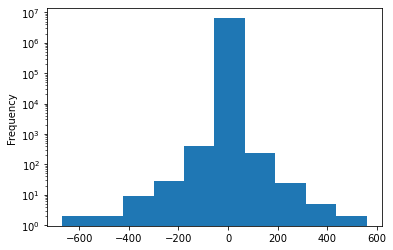

In [42]:
# Outliers were skewing the recommendations too much, so added line in surprisify to remove them:
#sur_df.value.plot(kind='hist', logy=True);

In [5]:
def readify(df):
    ma = max(df.value)
    mi = min(df.value)
    print('ma:', ma, '\nmi:', mi)
    reader = Reader(rating_scale=(mi, ma))
    data = Dataset.load_from_df(df[['dateID', 'symID', 'value']], reader)
    return data

In [6]:
def compare(actual, preds):
    print('actual mean', np.mean(actual))
    print('pred mean', np.mean(preds))
    print('actual std', np.std(actual))
    print('pred std', np.std(preds))
    print('actual max', np.max(actual))
    print('pred max', np.max(preds))
    print('actual min', np.min(actual))
    print('pred min', np.min(preds))    


In [7]:
def svd_predict(model, testset):
    predstest = []
    for x in testset:
        predstest.append(model.predict(x[0], x[1], x[2]))
    
    actual = [x[2] for x in predstest]
    preds = [x[3] for x in predstest]
    rMSE = MSE(actual, preds, squared=False)
    MAE = mae(predstest)
    print('\nMAE:', MAE)
    print('RMSE:', rMSE)
    compare(actual,preds)
    
    return predstest

In [8]:
sur_df = surprisify(df)
data = readify(sur_df)

trainset = data.build_full_trainset()
testset = trainset.build_testset()

sur_df std: 0.24990306377419882
sur_df len: 5247952
ma: 0.7874996751812233 
mi: -0.7562565210594983


In [ ]:
#param_grid = {'reg_all': [0.02, 0.1, 0.4], 'biased': [True, False]}
#param_grid = {'reg_all': [0.02, 0.01, 0.005, 0.001, 0], 'biased': [False]}
param_grid = {'reg_all': [0.005], 'biased': [False], 'n_epochs': [150], 'lr_all': [0.001]}
change_gscv = GSCV(SVD, param_grid, cv=5, refit=True, n_jobs= -1)
change_gscv.fit(data)

print(change_gscv.best_score)
print(change_gscv.best_params)
change_svd = change_gscv.best_estimator['rmse']

predstest = svd_predict(change_svd, testset)

dump.dump('models/svd/change_svd.p', algo=change_svd, predictions=predstest)

In [ ]:
#SVDpp: takes too long for now
# param_grid = {'reg_all': [0.02, 0.1]}
# change_svdpp = GSCV(SVDpp, param_grid, cv=3, n_jobs=4, refit=True)
# change_svdpp.fit(data)

C:\Users\Maltanno\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


### SVD on relative change

In [9]:
rel_df = pd.read_csv('rel_change.csv', index_col=0)
rel_df.head()

,A,AA,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,...,ZBH,ZEN,ZEPP,ZIM,ZNH,ZTO,ZTR,ZTS,ZUO,ZYME
1999-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-02,NaN,NaN,5.363985e-02,NaN,NaN,NaN,0.089028,NaN,NaN,-0.026601,...,NaN,NaN,NaN,NaN,-0.024616,NaN,4.726536e-03,NaN,NaN,NaN
1999-11-03,NaN,NaN,1.727273e-02,NaN,NaN,NaN,0.017883,NaN,NaN,-0.074074,...,NaN,NaN,NaN,NaN,0.015843,NaN,-3.249726e-13,NaN,NaN,NaN
1999-11-04,NaN,NaN,4.484993e-13,NaN,NaN,NaN,0.004863,NaN,NaN,0.012039,...,NaN,NaN,NaN,NaN,0.056236,NaN,0.000000e+00,NaN,NaN,NaN
1999-11-05,NaN,NaN,3.932082e-02,NaN,NaN,NaN,0.021542,NaN,NaN,-0.014198,...,NaN,NaN,NaN,NaN,0.035495,NaN,3.249726e-13,NaN,NaN,NaN


In [10]:
sur_rel_df = surprisify(rel_df)
rel_data = readify(sur_rel_df)

rel_trainset = rel_data.build_full_trainset()
rel_testset = rel_trainset.build_testset()

sur_df std: 0.010550485895147763
sur_df len: 5247953
ma: 0.0276115485559359 
mi: -0.0272549314905754


In [20]:
param_grid = {'reg_all': [0.02], 'biased': [False]}
rel_change_gscv = GSCV(SVD, param_grid, cv=5, refit=True, n_jobs= -1)
rel_change_gscv.fit(rel_data)

print(rel_change_gscv.best_score)
print(rel_change_gscv.best_params)
rel_change_svd = rel_change_gscv.best_estimator['rmse']

rel_predstest = svd_predict(rel_change_svd, rel_testset)

dump.dump('models/svd/rel_change_svd.p', algo=rel_change_svd, predictions=rel_predstest)

C:\Users\Maltanno\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'rmse': 0.010572809461804186, 'mae': 0.00814941529751569}
{'rmse': {'reg_all': 0.02, 'biased': False}, 'mae': {'reg_all': 0.02, 'biased': False}}
MAE:  0.0081

MAE: 0.008143591311586196
RMSE: 0.010566526058107546
actual mean 0.00037662949720158813
pred mean 7.164359554217163e-08
actual std 0.01056238022792759
pred std 0.00010692284978385201
actual max 0.0275121623888609
pred max 0.01437051455094787
actual min -0.0273549525700418
pred min -0.010776056463523878


The prediction seems better for the absolute change in values, I will use that going forwards.

## Proposition:
Some days are similar to others. I.e. The factors affecting stocks on one day have previously been in a similar circumstance and the stocks will change in a similar manner as how they previously did.

Issue:Performing SVD on the data at the end of the day is too late for making a prediction.   
Solution: Use midday values to make a prediction.     
Issue: May be able to get some midday results later, but currently would need to get a paid for account for the API
   
   

## Testing 



In [26]:
test_df = df.copy()
dates = {}
for row in range(len(test_df)-1):
    dates[test_df.iloc[:,0].index[row]] = test_df.iloc[row] + test_df.iloc[row+1]

In [30]:
test_df = pd.DataFrame(dates).transpose()
test_df.head()

,A,AA,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,...,K,KAI,KAMN,KAR,KB,KBH,KBR,KEN,KEP,KEX
1999-11-01,NaN,NaN,0.50,NaN,NaN,NaN,3.56,NaN,NaN,-1.44,...,-2.00,-0.12,-0.72,NaN,NaN,-0.31,NaN,NaN,0.94,-0.68
1999-11-02,NaN,NaN,0.12,NaN,NaN,NaN,1.25,NaN,NaN,-0.76,...,-1.38,-0.06,0.19,NaN,NaN,0.38,NaN,NaN,1.07,-0.31
1999-11-03,NaN,NaN,0.00,NaN,NaN,NaN,-0.63,NaN,NaN,-1.01,...,-1.75,0.06,0.60,NaN,NaN,-0.06,NaN,NaN,0.13,-0.37
1999-11-04,NaN,NaN,0.38,NaN,NaN,NaN,0.88,NaN,NaN,-0.63,...,-1.44,0.00,0.79,NaN,NaN,1.25,NaN,NaN,-0.88,-0.49
1999-11-05,NaN,NaN,0.06,NaN,NaN,NaN,-0.37,NaN,NaN,0.06,...,0.62,-0.06,0.97,NaN,NaN,1.63,NaN,NaN,-0.69,0.00


In [49]:
len(test_df)*0.2

1076.2

In [52]:
inds = random.sample(list(test_df.index), 1076)

In [54]:
test_df_test = test_df.loc[inds, :]
test_df_test.head()

,A,AA,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,...,K,KAI,KAMN,KAR,KB,KBH,KBR,KEN,KEP,KEX
2001-07-10,-3.09,NaN,-0.23,NaN,NaN,NaN,-1.62,0.18,NaN,-0.50,...,-0.16,0.02,-0.11,NaN,NaN,0.48,NaN,NaN,0.02,-0.66
2014-02-12,0.52,NaN,0.21,NaN,0.47,0.56,0.74,0.29,0.98,0.45,...,-0.11,1.50,0.73,-0.02,-0.02,0.16,0.59,NaN,0.34,2.09
2018-10-29,-0.28,-0.28,-0.08,NaN,-2.03,0.86,0.17,-0.11,-1.13,1.35,...,1.83,4.64,0.65,0.49,-1.23,0.02,-0.10,-0.02,-0.17,-0.54
2012-02-29,0.24,NaN,-0.34,NaN,-0.41,-0.71,0.31,-0.36,NaN,-0.18,...,-0.38,-0.25,0.42,-0.18,0.25,-0.14,0.09,NaN,-0.01,1.40
2003-04-22,1.15,NaN,0.45,NaN,2.57,NaN,1.01,0.13,NaN,-0.53,...,0.94,0.09,0.05,NaN,-0.60,2.27,NaN,NaN,0.08,0.24


In [56]:
test_df_train = test_df.drop(inds)
test_df_train.head()

,A,AA,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,...,K,KAI,KAMN,KAR,KB,KBH,KBR,KEN,KEP,KEX
1999-11-01,NaN,NaN,0.50,NaN,NaN,NaN,3.56,NaN,NaN,-1.44,...,-2.00,-0.12,-0.72,NaN,NaN,-0.31,NaN,NaN,0.94,-0.68
1999-11-02,NaN,NaN,0.12,NaN,NaN,NaN,1.25,NaN,NaN,-0.76,...,-1.38,-0.06,0.19,NaN,NaN,0.38,NaN,NaN,1.07,-0.31
1999-11-03,NaN,NaN,0.00,NaN,NaN,NaN,-0.63,NaN,NaN,-1.01,...,-1.75,0.06,0.60,NaN,NaN,-0.06,NaN,NaN,0.13,-0.37
1999-11-04,NaN,NaN,0.38,NaN,NaN,NaN,0.88,NaN,NaN,-0.63,...,-1.44,0.00,0.79,NaN,NaN,1.25,NaN,NaN,-0.88,-0.49
1999-11-05,NaN,NaN,0.06,NaN,NaN,NaN,-0.37,NaN,NaN,0.06,...,0.62,-0.06,0.97,NaN,NaN,1.63,NaN,NaN,-0.69,0.00


In [57]:
len(test_df_train)

4305

In [124]:
test_df_test.head()

,A,AA,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,...,K,KAI,KAMN,KAR,KB,KBH,KBR,KEN,KEP,KEX
2001-07-10,-3.09,NaN,-0.23,NaN,NaN,NaN,-1.62,0.18,NaN,-0.50,...,-0.16,0.02,-0.11,NaN,NaN,0.48,NaN,NaN,0.02,-0.66
2014-02-12,0.52,NaN,0.21,NaN,0.47,0.56,0.74,0.29,0.98,0.45,...,-0.11,1.50,0.73,-0.02,-0.02,0.16,0.59,NaN,0.34,2.09
2018-10-29,-0.28,-0.28,-0.08,NaN,-2.03,0.86,0.17,-0.11,-1.13,1.35,...,1.83,4.64,0.65,0.49,-1.23,0.02,-0.10,-0.02,-0.17,-0.54
2012-02-29,0.24,NaN,-0.34,NaN,-0.41,-0.71,0.31,-0.36,NaN,-0.18,...,-0.38,-0.25,0.42,-0.18,0.25,-0.14,0.09,NaN,-0.01,1.40
2003-04-22,1.15,NaN,0.45,NaN,2.57,NaN,1.01,0.13,NaN,-0.53,...,0.94,0.09,0.05,NaN,-0.60,2.27,NaN,NaN,0.08,0.24


In [141]:
test_dates = [np.datetime64(x) for x in test_df_test.index]

In [172]:
#list of previous days
test_dates_prev = [np.datetime64(x) -1 for x in test_df_test.index]


In [59]:
sur_train = surprisify(test_df_train)
sur_train.head()

,symID,dateID,value
0,A,1999-11-18,-4.06
1,A,1999-11-19,0.13
2,A,1999-11-22,0.44
3,A,1999-11-24,1.24
4,A,1999-11-29,1.32


In [109]:
train = readify(sur_train)
train = train.build_full_trainset()
test_algo = SVD()
test_algo.fit(train)


## KNN

In [9]:
load = dump.load('models/svd/change_svd.p')
svd = load[1]

In [10]:
days_df = pd.DataFrame(svd.pu)
days_df.index = df.loc['2004-11-01':'2018-11-01'].index
days_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2018-10-26,-0.017681,-0.030037,0.007010,-0.056040,-0.013096,-0.043383,0.023906,-0.129754,0.125933,0.000459,...,0.023024,-0.011390,0.029439,-0.048793,-0.008432,-0.094443,0.037733,-0.121666,0.013217,0.082606
2018-10-29,-0.055015,-0.043319,-0.095077,0.173342,-0.232825,-0.033182,0.043343,-0.247955,0.094256,-0.024082,...,0.167429,-0.049667,-0.083390,-0.281474,0.147189,0.031788,0.027674,-0.176813,0.071061,0.259893
2018-10-30,0.139604,0.056668,0.050205,-0.206252,-0.133817,-0.096923,-0.055339,0.096933,-0.146488,0.152315,...,-0.174886,0.085448,0.115786,0.290035,-0.176873,-0.126516,-0.097975,0.126158,-0.083240,-0.230575
2018-10-31,0.023067,-0.099067,-0.129650,0.090341,-0.039320,0.119180,-0.001036,-0.178746,0.024153,0.020612,...,0.151266,0.055136,-0.079353,-0.131755,0.045937,-0.052744,0.130325,-0.182717,0.105395,0.148380
2018-11-01,0.050889,0.112854,0.125979,-0.191887,-0.020171,-0.211083,0.041692,0.224726,0.026027,0.084713,...,-0.149838,0.034499,0.070586,0.186385,-0.025320,-0.185937,-0.092210,0.251331,-0.138556,-0.232047


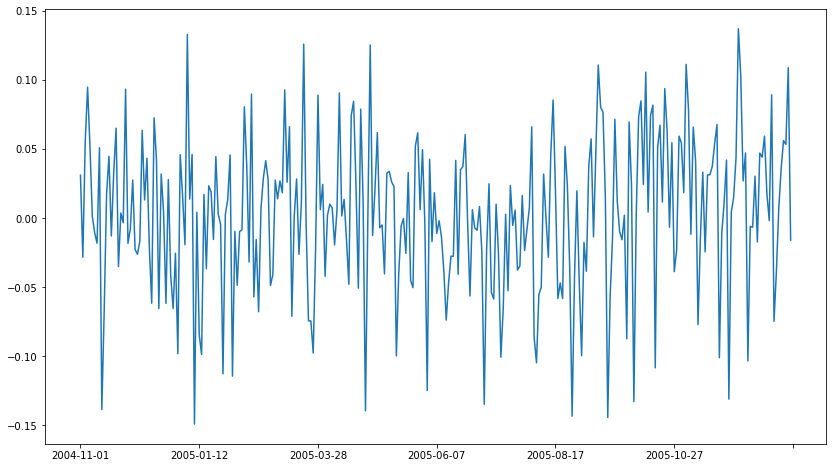

In [50]:
days_df.iloc[:300, 0].plot(figsize=(14, 8));

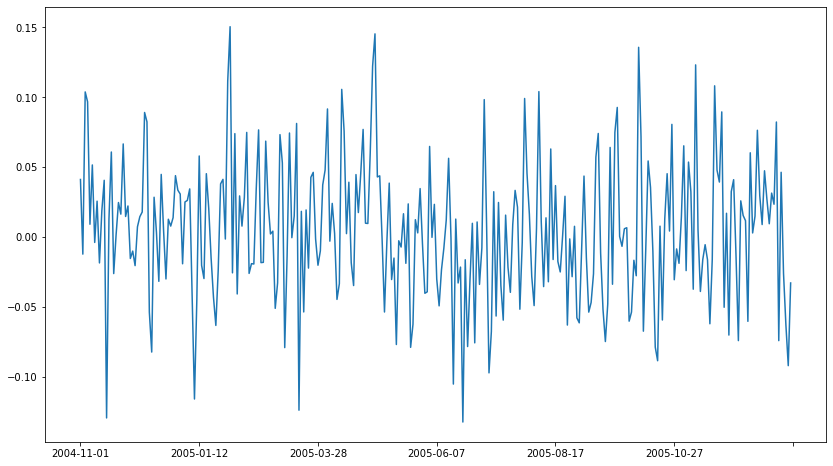

In [55]:
days_df.iloc[:300, 1].plot(figsize=(14, 8));

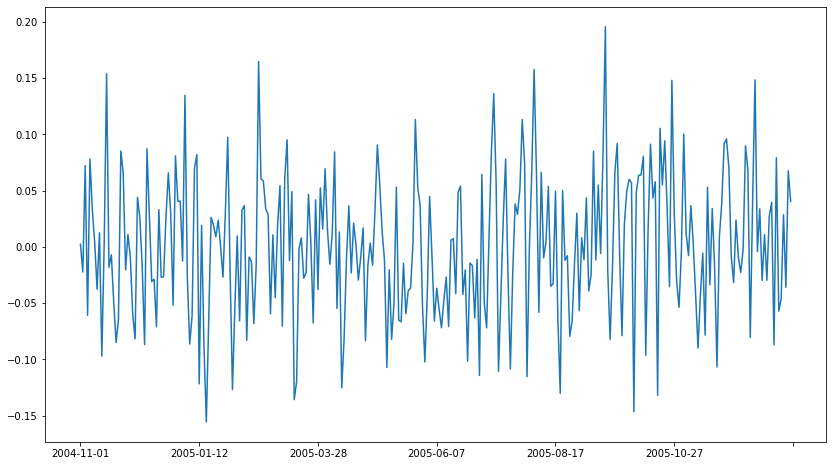

In [56]:
days_df.iloc[:300, 2].plot(figsize=(14, 8));

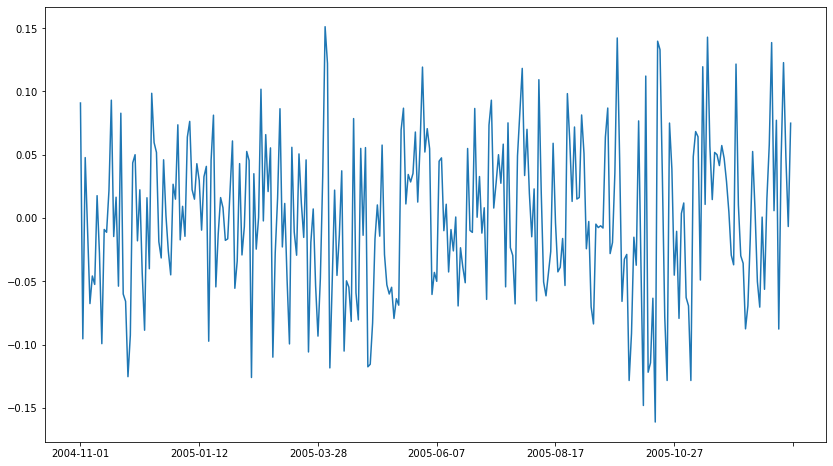

In [57]:
days_df.iloc[:300, 3].plot(figsize=(14, 8));

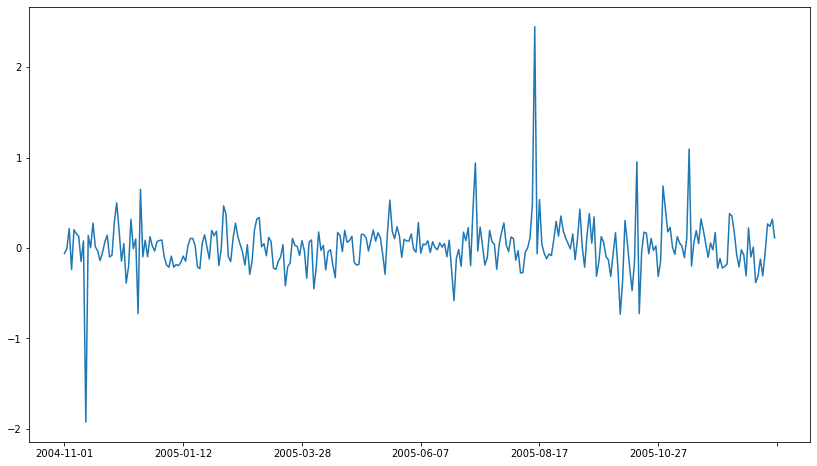

In [54]:
df.loc['2004-11-01':'2018-11-01'].iloc[:300, 0].plot(figsize=(14, 8));

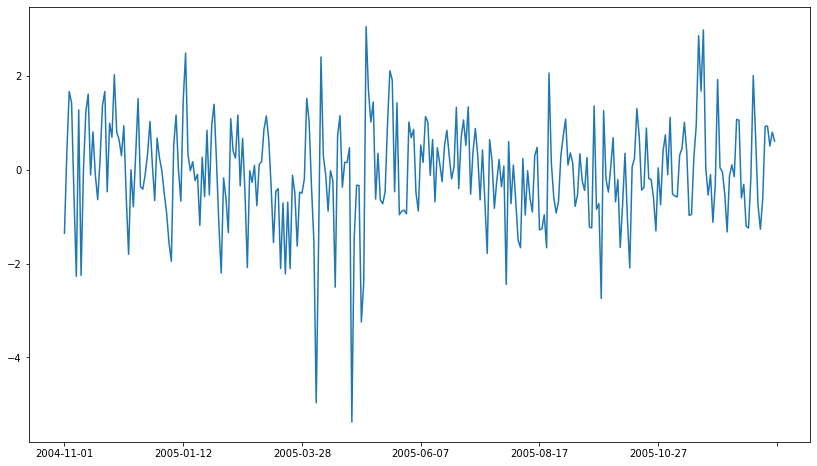

In [61]:
df.loc['2004-11-01':'2018-11-01'].iloc[:300, 2].plot(figsize=(14, 8));

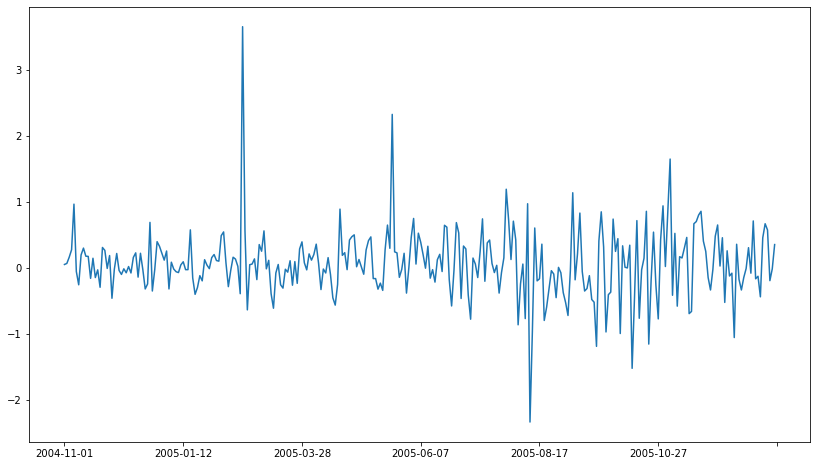

In [62]:
df.loc['2004-11-01':'2018-11-01'].iloc[:300, 4].plot(figsize=(14, 8));

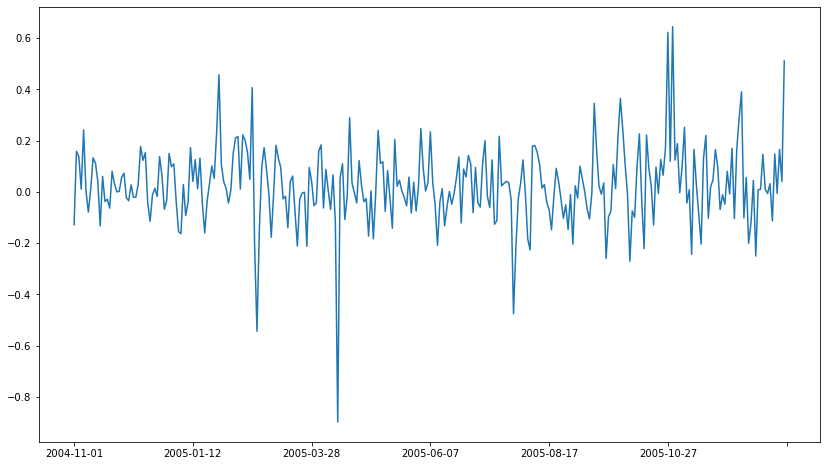

In [64]:
df.loc['2004-11-01':'2018-11-01'].iloc[:300, 6].plot(figsize=(14, 8));

In [11]:
# Find 7 nearest neighbours of each point, with distances
ss = SS()
scaled = ss.fit_transform(days_df)

nn = NN(n_neighbors = 5)
nn.fit(scaled)
neighbours = nn.kneighbors(X=days_df)

In [79]:
days_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2004-11-01,0.030869,0.041181,0.002410,0.090886,0.024696,0.029699,0.044415,-0.007906,0.038873,-0.021737,...,-0.008803,0.011189,0.039436,0.055819,-0.024752,-0.059093,0.033015,0.001395,0.056882,0.027529
2004-11-02,-0.028444,-0.012252,-0.022267,-0.095481,-0.035775,-0.090459,-0.031078,-0.061536,0.072384,0.001347,...,-0.053602,0.010959,-0.007857,-0.066359,0.000523,-0.117980,0.050334,-0.158815,0.008575,0.078475
2004-11-03,0.054903,0.103863,0.072222,0.047759,-0.062423,-0.014193,0.005074,-0.008923,0.188108,0.041462,...,0.101447,-0.060580,-0.071388,-0.092917,0.035915,-0.037895,-0.023294,0.014129,0.061619,0.026331
2004-11-04,0.094613,0.096794,-0.060737,-0.011119,-0.032154,-0.017165,-0.018314,-0.137625,0.034038,0.074800,...,0.064806,0.028566,0.052914,-0.038700,0.058721,0.048486,-0.035824,-0.002340,-0.031990,-0.016620
2004-11-05,0.052021,0.009133,0.078193,-0.067614,-0.104540,-0.069337,-0.011528,-0.017581,0.218775,0.053026,...,0.115883,-0.011174,0.015390,-0.003401,-0.018816,-0.019080,0.108082,-0.026992,0.104747,0.021539


In [14]:
def nn_pred(df, neighbours):
    preds = {}
    for i, row in enumerate(df[1:].index):
        w_num = 1 / np.sum(1 / np.square(neighbours[0][i]))
        w_den = np.square(neighbours[0][i])
        weights = w_num / w_den
        vals = df.iloc[neighbours[1][0]-1].transpose() * weights
        preds[row] = vals.transpose().sum()
    return preds

In [15]:
def nn_results(df, ss, preds):
    preds_df = pd.DataFrame(preds).transpose()
    uns_preds = pd.DataFrame(ss.inverse_transform(preds_df), index=preds_df.index)
    
    list_preds = np.reshape(np.array(uns_preds), -1)
    list_true = np.reshape(np.array(df[1:]), -1)
    rmse = MSE(list_true, list_preds, squared=False)
    print('RMSE: ', rmse)
    compare(list_true, list_preds)
    
    print('\nBASELINE RMSE:')
    base_true = list_true[df.shape[1]:]
    base_preds = list_true[:-df.shape[1]]
    rmse = MSE(base_true, base_preds, squared=False)
    print(rmse)


In [16]:
preds = nn_pred(days_df, neighbours)
nn_results(days_df, ss, preds)

RMSE:  0.07515076197509442
actual mean 0.0006881582797717348
pred mean 0.0005611113859424029
actual std 0.07521758889703965
pred std 0.004896769738220742
actual max 0.4621352454220627
pred max 0.012497912357492591
actual min -0.4626614849674878
pred min -0.012829473276606086

BASELINE RMSE:
0.09862612282779348


This is bad:

Too many dimensions    
Only finds similarities on the same scale    
Values cancelling   

### PCA

In [17]:
pca = PCA(n_components=10)
pca_df = pd.DataFrame(pca.fit_transform(days_df))
print(np.cumsum(pca.explained_variance_ratio_))


[0.22701137 0.28899111 0.34266332 0.37899042 0.41132902 0.44006264
 0.46684546 0.49191942 0.51287295 0.53109478]


In [18]:
pca_ss = SS()
pca_scaled = pca_ss.fit_transform(pca_df)

pca_nn = NN(n_neighbors = 5)
pca_nn.fit(pca_scaled)
pca_neighbours = pca_nn.kneighbors(X=pca_df)

In [19]:
pca_preds = nn_pred(pca_df, pca_neighbours)
nn_results(pca_df, pca_ss, pca_preds)

RMSE:  0.17358031885097738
actual mean 4.540763419304706e-07
pred mean 0.006532451270089181
actual std 0.17311657692651305
pred std 0.010396368695225214
actual max 1.2864078362124978
pred max 0.05518755024045233
actual min -1.231014359191785
pred min -0.04402328633888253

BASELINE RMSE:
0.2227690897234497


## Test
Some days are similar to others.   
1st test:    
A rough test I want to do to begin -Can tomorrow's changes be approximated by the changes seen in the first days after those most similar to today?
Not expecting too much from this -as its only going back one day- especially if PCA is needed.

In [183]:
#Baseline, random walk: use the value for the day before



So far I've been treating each day's values as inseparable. Also, putting each day separately into the SVD algorithm, I was  only able to look one day back. I hoped there was enough information in each day's state to show where it was going, but that was a bit too much to ask of it.       

I'm next going to go for an opposite approach: consider the day's values separately, but look further back in time.   
Next: LSTMs    
    
Another idea is to try nearest neighbours again but for the SVD, for each day, instead just that day's \~2500 stock values, use all the values for the last week (~12500 stock values) or multiple weeks

## LSTM


Notes: standardisation -not min-max scaling

In [12]:
#Note: scaled is from the KNN section,the scaled user matrix from thse SVD
s_df = pd.DataFrame(scaled, index=days_df.index)

In [13]:
lstm_data = {}

for i in range(100):
    
    X = []
    y = []

    for j in range(90, s_df.shape[0]-1):
        X.append(s_df.iloc[j-90:j,i])
        y.append(s_df.iloc[j ,i])
    lstm_data[i] = (X, y)

In [14]:
s_df.shape

(3527, 100)

Test 1: last days of s_df -note probably no to much effect, but data from those days is used in creating s_df. 
Test 2: days beyond s_df for which I'll create another SVD

In [32]:
# i=0
# X = np.array(lstm_data[i][0])
# y = np.array(lstm_data[i][1])
# test_len = 120
# ind_val = np.random.choice(X.shape[0]-test_len, int(X.shape[0]/10), replace=False)
# ind_train = [x for x in range(X.shape[0]-test_len) if x not in ind_val]
# X_train = X[ind_train]
# y_train = y[ind_train]
# X_val = X[ind_val]
# y_val = y[ind_val]
# X_test = X[-test_len:]
# y_test = y[-test_len:]

In [74]:
i=0
X = np.array(lstm_data[i][0])
y = np.array(lstm_data[i][1])
test_len = 120
ind_val = np.random.choice(X.shape[0]-test_len, int(X.shape[0]/10), replace=False)
ind_train = [x for x in range(X.shape[0]-test_len) if x not in ind_val]
X_train = X[ind_train]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = y[ind_train]
X_val = X[ind_val]
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
y_val = y[ind_val]
X_test = X[-test_len:]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = y[-test_len:]

In [75]:
print(X.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3436, 90)
(2973, 90, 1)
(343, 90, 1)
(120, 90, 1)


### Hyperparameter Tuning

In [62]:
def talos_model(X_train, y_train, X_val, y_val, tal_params):
    
    model = Sequential()
    model.add(LSTM(units=64, stateful=tal_params['stateful'], 
                   use_bias=tal_params['use_bias'], 
                   activation=tal_params['activation'], 
                   return_sequences=True, 
                   input_shape=((X_train.shape[1],1))))
#    model.add(Dropout(0.1))
    model.add(LSTM(units=64, stateful=tal_params['stateful'], 
                   use_bias=tal_params['use_bias'], 
                   activation=tal_params['activation'], 
                   return_sequences=True))
#    model.add(Dropout(0.1))
    model.add(LSTM(units=32, stateful=tal_params['stateful'], 
                   use_bias=tal_params['use_bias'], 
                   activation=tal_params['activation']))
#    model.add(Dropout(0.1))
    model.add(Dense(units=1))
    
    es = EarlyStopping(patience=10, restore_best_weights=True)
    mc = ModelCheckpoint(f'models/{i}.h5', save_best_only=True)
    cb = [mc, es]
    
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=50, 
                        batch_size=tal_params['batch_size'], 
                        validation_data=(X_val, y_val), callbacks=cb)    


    return history, model

In [63]:
#tal_params = {'activation': ['relu', 'elu', 'tanh', 'selu']}
tal_params = {'activation': ['relu', 'elu', 'tanh', 'selu'],
              'optimizer': ['adam'],
              'use_bias': [True],
              'stateful': [False],
              'batch_size': [160]
             }

try:
    t1=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-1--------------------------------')
    
tal_params = {'activation': ['relu'],
              'optimizer': ['adam', 'RMSprop', 'SGD', 'Nadam'],
              'use_bias': [True],
              'stateful': [False],
              'batch_size': [160]
             }

try:
    t2=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-2--------------------------------')
    
tal_params = {'activation': ['relu'],
              'optimizer': ['adam'],
              'use_bias': [True, False],
              'stateful': [True, False],
              'batch_size': [160]
             }

try:
    t3=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-3--------------------------------')
    
tal_params = {'activation': ['relu'],
              'optimizer': ['adam'],
              'use_bias': [True],
              'stateful': [False],
              'batch_size': [20, 50, 100, 150, 200, 300, 400, 600]
             }

try:
    t4=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-4--------------------------------')


    
    


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/50
19/19 [==============================] - 26s 737ms/step - loss: 1.0060 - val_loss: 1.1103
Epoch 2/50
19/19 [==============================] - 12s 581ms/step - loss: 1.0200 - val_loss: 1.1107
Epoch 3/50
19/19 [==============================] - 13s 665ms/step - loss: 1.0050 - val_loss: 1.1111
Epoch 4/50
19/19 [==============================] - 12s 616ms/step - loss: 1.0045 - val_loss: 1.1108
Epoch 5/50
19/19 [==============================] - 8s 419ms/step - loss: 0.9687 - val_loss: 1.1107
Epoch 6/50
19/19 [==============================] - 8s 444ms/step - loss: 0.9830 - val_loss: 1.1105
Epoch 7/50
19/19 [==============================] - 13s 694ms/step - loss: 1.0191 - val_loss: 1.1109
Epoch 8/50
19/19 [==============================] - 11s 547ms/step - loss: 0.9736 - val_loss: 1.1108
Epoch 9/50
19/19 [==============================] - 9s 489ms/step - loss: 1.0205 - val_loss: 1.1110
Epoch 10/50
19/19 [==============================] - 8s 414ms/step - loss: 0.9731 - val_loss: 

 25%|██▌       | 1/4 [02:16<06:48, 136.21s/it]

Epoch 1/50
19/19 [==============================] - 27s 838ms/step - loss: 0.9734 - val_loss: 1.1087
Epoch 2/50
19/19 [==============================] - 9s 462ms/step - loss: 0.9947 - val_loss: 1.1088
Epoch 3/50
19/19 [==============================] - 6s 324ms/step - loss: 0.9678 - val_loss: 1.1089
Epoch 4/50
19/19 [==============================] - 5s 283ms/step - loss: 0.9892 - val_loss: 1.1072
Epoch 5/50
19/19 [==============================] - 6s 344ms/step - loss: 0.9540 - val_loss: 1.1074
Epoch 6/50
19/19 [==============================] - 5s 287ms/step - loss: 0.9900 - val_loss: 1.1073
Epoch 7/50
19/19 [==============================] - 5s 284ms/step - loss: 1.0269 - val_loss: 1.1078
Epoch 8/50
19/19 [==============================] - 5s 284ms/step - loss: 0.9857 - val_loss: 1.1067
Epoch 9/50
19/19 [==============================] - 6s 301ms/step - loss: 1.0094 - val_loss: 1.1063
Epoch 10/50
19/19 [==============================] - 12s 584ms/step - loss: 0.9370 - val_loss: 1.10

 50%|█████     | 2/4 [05:18<05:26, 163.23s/it]

Epoch 1/50
19/19 [==============================] - 33s 895ms/step - loss: 1.0164 - val_loss: 1.1087
Epoch 2/50
19/19 [==============================] - 14s 744ms/step - loss: 1.0257 - val_loss: 1.1085
Epoch 3/50
19/19 [==============================] - 10s 513ms/step - loss: 0.9734 - val_loss: 1.1082
Epoch 4/50
19/19 [==============================] - 8s 443ms/step - loss: 0.9770 - val_loss: 1.1083
Epoch 5/50
19/19 [==============================] - 16s 807ms/step - loss: 1.0368 - val_loss: 1.1079
Epoch 6/50
19/19 [==============================] - 13s 638ms/step - loss: 0.9612 - val_loss: 1.1079
Epoch 7/50
19/19 [==============================] - 8s 415ms/step - loss: 0.9995 - val_loss: 1.1067
Epoch 8/50
19/19 [==============================] - 15s 770ms/step - loss: 0.9571 - val_loss: 1.1078
Epoch 9/50
19/19 [==============================] - 13s 669ms/step - loss: 1.0015 - val_loss: 1.1069
Epoch 10/50
19/19 [==============================] - 12s 630ms/step - loss: 1.0114 - val_loss

 75%|███████▌  | 3/4 [09:02<03:11, 191.17s/it]

Epoch 1/50
19/19 [==============================] - 22s 573ms/step - loss: 1.0932 - val_loss: 1.1600
Epoch 2/50
19/19 [==============================] - 14s 691ms/step - loss: 1.0178 - val_loss: 1.1061
Epoch 3/50
19/19 [==============================] - 14s 721ms/step - loss: 0.9763 - val_loss: 1.1076
Epoch 4/50
19/19 [==============================] - 14s 732ms/step - loss: 0.9805 - val_loss: 1.1097
Epoch 5/50
19/19 [==============================] - 9s 459ms/step - loss: 1.0008 - val_loss: 1.1153
Epoch 6/50
19/19 [==============================] - 8s 414ms/step - loss: 0.9642 - val_loss: 1.1191
Epoch 7/50
19/19 [==============================] - 7s 380ms/step - loss: 0.9787 - val_loss: 1.1187
Epoch 8/50
19/19 [==============================] - 14s 704ms/step - loss: 0.9743 - val_loss: 1.1231
Epoch 9/50
19/19 [==============================] - 12s 582ms/step - loss: 0.9401 - val_loss: 1.1178
Epoch 10/50
19/19 [==============================] - 13s 676ms/step - loss: 0.9275 - val_loss:

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/50
19/19 [==============================] - 23s 677ms/step - loss: 0.9838 - val_loss: 1.1109
Epoch 2/50
19/19 [==============================] - 10s 502ms/step - loss: 0.9649 - val_loss: 1.1110
Epoch 3/50
19/19 [==============================] - 14s 719ms/step - loss: 0.9817 - val_loss: 1.1108
Epoch 4/50
19/19 [==============================] - 14s 734ms/step - loss: 0.9599 - val_loss: 1.1107
Epoch 5/50
19/19 [==============================] - 12s 625ms/step - loss: 1.0199 - val_loss: 1.1107
Epoch 6/50
19/19 [==============================] - 7s 359ms/step - loss: 0.9836 - val_loss: 1.1112
Epoch 7/50
19/19 [==============================] - 14s 691ms/step - loss: 0.9800 - val_loss: 1.1106
Epoch 8/50
19/19 [==============================] - 13s 673ms/step - loss: 0.9602 - val_loss: 1.1107
Epoch 9/50
19/19 [==============================] - 10s 516ms/step - loss: 0.9868 - val_loss: 1.1102
Epoch 10/50
19/19 [==============================] - 9s 477ms/step - loss: 0.9845 - val_loss

 25%|██▌       | 1/4 [07:12<21:37, 432.44s/it]

Epoch 1/50
19/19 [==============================] - 26s 776ms/step - loss: 0.9967 - val_loss: 1.1110
Epoch 2/50
19/19 [==============================] - 14s 732ms/step - loss: 1.0027 - val_loss: 1.1112
Epoch 3/50
19/19 [==============================] - 16s 806ms/step - loss: 1.0155 - val_loss: 1.1106
Epoch 4/50
19/19 [==============================] - 16s 839ms/step - loss: 1.0331 - val_loss: 1.1105
Epoch 5/50
19/19 [==============================] - 10s 540ms/step - loss: 0.9730 - val_loss: 1.1108
Epoch 6/50
19/19 [==============================] - 8s 397ms/step - loss: 0.9858 - val_loss: 1.1104
Epoch 7/50
19/19 [==============================] - 16s 811ms/step - loss: 0.9657 - val_loss: 1.1103
Epoch 8/50
19/19 [==============================] - 14s 729ms/step - loss: 0.9817 - val_loss: 1.1098
Epoch 9/50
19/19 [==============================] - 16s 838ms/step - loss: 1065.4799 - val_loss: 1.1108
Epoch 10/50
19/19 [==============================] - 16s 856ms/step - loss: 0.9717 - val_

 50%|█████     | 2/4 [11:45<11:17, 338.57s/it]

Epoch 1/50
19/19 [==============================] - 24s 727ms/step - loss: 0.9711 - val_loss: 1.1107
Epoch 2/50
19/19 [==============================] - 13s 661ms/step - loss: 1.0040 - val_loss: 1.1107
Epoch 3/50
19/19 [==============================] - 8s 439ms/step - loss: 1.0300 - val_loss: 1.1108
Epoch 4/50
19/19 [==============================] - 7s 347ms/step - loss: 0.9886 - val_loss: 1.1112
Epoch 5/50
19/19 [==============================] - 5s 274ms/step - loss: 0.9714 - val_loss: 1.1109
Epoch 6/50
19/19 [==============================] - 12s 625ms/step - loss: 0.9799 - val_loss: 1.1108
Epoch 7/50
19/19 [==============================] - 12s 582ms/step - loss: 0.9566 - val_loss: 1.1106
Epoch 8/50
19/19 [==============================] - 9s 443ms/step - loss: 1.0340 - val_loss: 1.1106
Epoch 9/50
19/19 [==============================] - 15s 753ms/step - loss: 0.9896 - val_loss: 1.1106
Epoch 10/50
19/19 [==============================] - 12s 611ms/step - loss: 0.9596 - val_loss: 

 75%|███████▌  | 3/4 [19:49<06:45, 405.17s/it]

Epoch 1/50
19/19 [==============================] - 25s 738ms/step - loss: 0.9884 - val_loss: 1.1112
Epoch 2/50
19/19 [==============================] - 13s 637ms/step - loss: 0.9791 - val_loss: 1.1109
Epoch 3/50
19/19 [==============================] - 8s 431ms/step - loss: 0.9606 - val_loss: 1.1111
Epoch 4/50
19/19 [==============================] - 11s 565ms/step - loss: 0.9705 - val_loss: 1.1107
Epoch 5/50
19/19 [==============================] - 11s 591ms/step - loss: 0.9657 - val_loss: 1.1110
Epoch 6/50
19/19 [==============================] - 15s 765ms/step - loss: 0.9914 - val_loss: 1.1109
Epoch 7/50
19/19 [==============================] - 7s 389ms/step - loss: 1.0164 - val_loss: 1.1103
Epoch 8/50
19/19 [==============================] - 13s 655ms/step - loss: 0.9458 - val_loss: 1.1108
Epoch 9/50
19/19 [==============================] - 9s 459ms/step - loss: 1.0145 - val_loss: 1.1108
Epoch 10/50
19/19 [==============================] - 6s 311ms/step - loss: 0.9852 - val_loss: 

  0%|          | 0/8 [00:00<?, ?it/s]

Error-3--------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/50


149/149 [==============================] - 25s 98ms/step - loss: 1.0197 - val_loss: 1.1115
Epoch 2/50
149/149 [==============================] - 11s 75ms/step - loss: 0.9682 - val_loss: 1.1111
Epoch 3/50
149/149 [==============================] - 11s 76ms/step - loss: 0.9944 - val_loss: 1.1112
Epoch 4/50
149/149 [==============================] - 11s 75ms/step - loss: 0.9653 - val_loss: 1.1114
Epoch 5/50
149/149 [==============================] - 12s 79ms/step - loss: 0.9832 - val_loss: 1.1110
Epoch 6/50
149/149 [==============================] - 12s 79ms/step - loss: 0.9832 - val_loss: 1.1111
Epoch 7/50
149/149 [==============================] - 12s 83ms/step - loss: 0.9699 - val_loss: 1.1110
Epoch 8/50
149/149 [==============================] - 27s 178ms/step - loss: 0.9781 - val_loss: 1.1109
Epoch 9/50
149/149 [==============================] - 16s 104ms/step - loss: 0.9593 - val_loss: 1.1109
Epoch 10/50
149/149 [==============================] - 15s 98ms/step - loss: 0.9494 - val_l


 12%|█▎        | 1/8 [16:20<1:54:25, 980.83s/it]

Epoch 1/50
60/60 [==============================] - 21s 163ms/step - loss: 0.9876 - val_loss: 1.1111
Epoch 2/50
60/60 [==============================] - 7s 110ms/step - loss: 0.9718 - val_loss: 1.1110
Epoch 3/50
60/60 [==============================] - 7s 111ms/step - loss: 1.0346 - val_loss: 1.1112
Epoch 4/50
60/60 [==============================] - 6s 97ms/step - loss: 0.9915 - val_loss: 1.1109
Epoch 5/50
60/60 [==============================] - 6s 96ms/step - loss: 0.9762 - val_loss: 1.1116
Epoch 6/50
60/60 [==============================] - 11s 181ms/step - loss: 0.9623 - val_loss: 1.1107
Epoch 7/50
60/60 [==============================] - 11s 175ms/step - loss: 1.0019 - val_loss: 1.1109
Epoch 8/50
60/60 [==============================] - 7s 116ms/step - loss: 0.9693 - val_loss: 1439.9869
Epoch 9/50
60/60 [==============================] - 6s 100ms/step - loss: 118.7930 - val_loss: 1.1114
Epoch 10/50
60/60 [==============================] - 6s 105ms/step - loss: 1.0260 - val_loss: 


 25%|██▌       | 2/8 [20:08<53:48, 538.08s/it]  

Epoch 1/50
30/30 [==============================] - 23s 420ms/step - loss: 0.9599 - val_loss: 1.1108
Epoch 2/50
30/30 [==============================] - 10s 330ms/step - loss: 0.9839 - val_loss: 1.1114
Epoch 3/50
30/30 [==============================] - 7s 233ms/step - loss: 1.0418 - val_loss: 1.1111
Epoch 4/50
30/30 [==============================] - 10s 334ms/step - loss: 0.9740 - val_loss: 1.1110
Epoch 5/50
30/30 [==============================] - 8s 261ms/step - loss: 0.9996 - val_loss: 1.1103
Epoch 6/50
30/30 [==============================] - 13s 430ms/step - loss: 0.9132 - val_loss: 1.1108
Epoch 7/50
30/30 [==============================] - 13s 438ms/step - loss: 1.0006 - val_loss: 1.1110
Epoch 8/50
30/30 [==============================] - 12s 395ms/step - loss: 0.9775 - val_loss: 1.1117
Epoch 9/50
30/30 [==============================] - 8s 269ms/step - loss: 0.9678 - val_loss: 1.1102
Epoch 10/50
30/30 [==============================] - 11s 368ms/step - loss: 0.9990 - val_loss:


 38%|███▊      | 3/8 [28:47<44:06, 529.23s/it]

Epoch 1/50
20/20 [==============================] - 31s 1s/step - loss: 1.0114 - val_loss: 1.1111
Epoch 2/50
20/20 [==============================] - 16s 791ms/step - loss: 1.0031 - val_loss: 1.1116
Epoch 3/50
20/20 [==============================] - 15s 722ms/step - loss: 0.9990 - val_loss: 1.1106
Epoch 4/50
20/20 [==============================] - 9s 428ms/step - loss: 1.0442 - val_loss: 1.1105
Epoch 5/50
20/20 [==============================] - 9s 464ms/step - loss: 1.0173 - val_loss: 1.1117
Epoch 6/50
20/20 [==============================] - 15s 724ms/step - loss: 0.9950 - val_loss: 1.1105
Epoch 7/50
20/20 [==============================] - 17s 845ms/step - loss: 0.9633 - val_loss: 1.1113
Epoch 8/50
20/20 [==============================] - 14s 682ms/step - loss: 1812661.2765 - val_loss: 1.1107
Epoch 9/50
20/20 [==============================] - 19s 919ms/step - loss: 0.9929 - val_loss: 1.1107
Epoch 10/50
20/20 [==============================] - 16s 755ms/step - loss: 0.9906 - val_l


 50%|█████     | 4/8 [32:24<27:03, 405.84s/it]

Epoch 1/50
15/15 [==============================] - 23s 788ms/step - loss: 0.9709 - val_loss: 1.1119
Epoch 2/50
15/15 [==============================] - 13s 802ms/step - loss: 1.0017 - val_loss: 1.1112
Epoch 3/50
15/15 [==============================] - 11s 709ms/step - loss: 1.0204 - val_loss: 1.1113
Epoch 4/50
15/15 [==============================] - 12s 755ms/step - loss: 1.0157 - val_loss: 1.1109
Epoch 5/50
15/15 [==============================] - 12s 737ms/step - loss: 0.9562 - val_loss: 1.1110
Epoch 6/50
15/15 [==============================] - 12s 775ms/step - loss: 0.9740 - val_loss: 1.1108
Epoch 7/50
15/15 [==============================] - 9s 625ms/step - loss: 1.0214 - val_loss: 1.1106
Epoch 8/50
15/15 [==============================] - 10s 606ms/step - loss: 0.9751 - val_loss: 1.1111
Epoch 9/50
15/15 [==============================] - 7s 473ms/step - loss: 0.9858 - val_loss: 1.1105
Epoch 10/50
15/15 [==============================] - 11s 717ms/step - loss: 0.9723 - val_loss


 62%|██████▎   | 5/8 [37:42<18:42, 374.30s/it]

Epoch 1/50
10/10 [==============================] - 24s 1s/step - loss: 1.0328 - val_loss: 1.1110
Epoch 2/50
10/10 [==============================] - 16s 2s/step - loss: 0.9617 - val_loss: 1.1112
Epoch 3/50
10/10 [==============================] - 14s 1s/step - loss: 0.9915 - val_loss: 1.1104
Epoch 4/50
10/10 [==============================] - 6s 640ms/step - loss: 1.0213 - val_loss: 1.1110
Epoch 5/50
10/10 [==============================] - 11s 1s/step - loss: 1.0004 - val_loss: 1.1107
Epoch 6/50
10/10 [==============================] - 14s 1s/step - loss: 0.9748 - val_loss: 1.1106
Epoch 7/50
10/10 [==============================] - 15s 1s/step - loss: 0.9819 - val_loss: 1.1104
Epoch 8/50
10/10 [==============================] - 12s 1s/step - loss: 1.0111 - val_loss: 1.1102
Epoch 9/50
10/10 [==============================] - 14s 1s/step - loss: 1.0008 - val_loss: 1.1101
Epoch 10/50
10/10 [==============================] - 12s 1s/step - loss: 0.9886 - val_loss: 1.1097
Epoch 11/50
10/10


 75%|███████▌  | 6/8 [42:31<11:30, 345.20s/it]

Epoch 1/50
8/8 [==============================] - 24s 2s/step - loss: 1.0047 - val_loss: 1.1111
Epoch 2/50
8/8 [==============================] - 14s 2s/step - loss: 0.9923 - val_loss: 1.1124
Epoch 3/50
8/8 [==============================] - 12s 1s/step - loss: 0.9967 - val_loss: 1.1108
Epoch 4/50
8/8 [==============================] - 11s 1s/step - loss: 0.9836 - val_loss: 1.1107
Epoch 5/50
8/8 [==============================] - 9s 1s/step - loss: 0.9943 - val_loss: 1.1109
Epoch 6/50
8/8 [==============================] - 15s 2s/step - loss: 0.9887 - val_loss: 1.1108
Epoch 7/50
8/8 [==============================] - 12s 1s/step - loss: 1.0065 - val_loss: 1.1105
Epoch 8/50
8/8 [==============================] - 8s 996ms/step - loss: 1.0290 - val_loss: 1.1106
Epoch 9/50
8/8 [==============================] - 7s 922ms/step - loss: 0.9947 - val_loss: 1.1106
Epoch 10/50
8/8 [==============================] - 7s 837ms/step - loss: 0.9995 - val_loss: 1.1115
Epoch 11/50
8/8 [=================


 88%|████████▊ | 7/8 [47:48<05:36, 336.10s/it]

Epoch 1/50
5/5 [==============================] - 24s 3s/step - loss: 0.9658 - val_loss: 1.1114
Epoch 2/50
5/5 [==============================] - 13s 2s/step - loss: 0.9720 - val_loss: 1.1111
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 0.9860 - val_loss: 1.1110
Epoch 4/50
5/5 [==============================] - 11s 2s/step - loss: 0.9876 - val_loss: 1.1107
Epoch 5/50
5/5 [==============================] - 14s 3s/step - loss: 0.9932 - val_loss: 1.1106
Epoch 6/50
5/5 [==============================] - 15s 3s/step - loss: 0.9697 - val_loss: 1.1105
Epoch 7/50
5/5 [==============================] - 14s 3s/step - loss: 0.9853 - val_loss: 1.1101
Epoch 8/50
5/5 [==============================] - 13s 3s/step - loss: 0.9805 - val_loss: 1.1108
Epoch 9/50
5/5 [==============================] - 13s 2s/step - loss: 1.0061 - val_loss: 1.1119
Epoch 10/50
5/5 [==============================] - 14s 3s/step - loss: 0.9838 - val_loss: 1.1123
Epoch 11/50
5/5 [=======================


100%|██████████| 8/8 [51:59<00:00, 390.00s/it]


In [70]:
# tal_params = {'activation': ['relu'],
#               'optimizer': ['adam'],
#               'use_bias': [True, False],
#               'stateful': [True],
#               'batch_size': [160]
#              }

# try:
#     t3a=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
#                  params=tal_params, model=talos_model, 
#                  experiment_name='talos_test')
# except:
#     print('Error-3a--------------------------------')
    
tal_params = {'activation': ['relu'],
              'optimizer': ['adam'],
              'use_bias': [True],
              'stateful': [False],
              'batch_size': [160]
             }

try:
    t3b=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-3b--------------------------------')
tal_params = {'activation': ['relu'],
              'optimizer': ['adam'],
              'use_bias': [False],
              'stateful': [False],
              'batch_size': [160]
             }

try:
    t3b=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-3c--------------------------------')
    
    
tal_params = {'activation': ['relu'],
              'optimizer': ['adam'],
              'use_bias': [False],
              'stateful': [True],
              'batch_size': [160]
             }

try:
    t3b=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-3d--------------------------------')
    
    
tal_params = {'activation': ['relu'],
              'optimizer': ['adam'],
              'use_bias': [True],
              'stateful': [True],
              'batch_size': [160]
             }

try:
    t3b=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-3e--------------------------------')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/50
19/19 [==============================] - 23s 525ms/step - loss: 0.9756 - val_loss: 1.1110
Epoch 2/50
19/19 [==============================] - 5s 282ms/step - loss: 0.9774 - val_loss: 1.1111
Epoch 3/50
19/19 [==============================] - 5s 284ms/step - loss: 0.9762 - val_loss: 1.1106
Epoch 4/50
19/19 [==============================] - 5s 279ms/step - loss: 1.0052 - val_loss: 1.1110
Epoch 5/50
19/19 [==============================] - 5s 286ms/step - loss: 0.9753 - val_loss: 1.1108
Epoch 6/50
19/19 [==============================] - 5s 279ms/step - loss: 0.9901 - val_loss: 1.1135
Epoch 7/50
19/19 [==============================] - 6s 302ms/step - loss: 0.9586 - val_loss: 1.1105
Epoch 8/50
19/19 [==============================] - 11s 566ms/step - loss: 0.9892 - val_loss: 1.1106
Epoch 9/50
19/19 [==============================] - 8s 397ms/step - loss: 0.9761 - val_loss: 1.1103
Epoch 10/50
19/19 [==============================] - 12s 621ms/step - loss: 1.0068 - val_loss: 1.1

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/50
19/19 [==============================] - 18s 472ms/step - loss: 0.9510 - val_loss: 1.1111
Epoch 2/50
19/19 [==============================] - 5s 258ms/step - loss: 0.9772 - val_loss: 1.1110
Epoch 3/50
19/19 [==============================] - 5s 247ms/step - loss: 0.9872 - val_loss: 1.1110
Epoch 4/50
19/19 [==============================] - 5s 254ms/step - loss: 1.0092 - val_loss: 1.1109
Epoch 5/50
19/19 [==============================] - 5s 249ms/step - loss: 0.9392 - val_loss: 1.1108
Epoch 6/50
19/19 [==============================] - 5s 262ms/step - loss: 1.0028 - val_loss: 1.1107
Epoch 7/50
19/19 [==============================] - 5s 268ms/step - loss: 0.9679 - val_loss: 1.1106
Epoch 8/50
19/19 [==============================] - 5s 271ms/step - loss: 0.9859 - val_loss: 1.1105
Epoch 9/50
19/19 [==============================] - 5s 254ms/step - loss: 0.9982 - val_loss: 1.1097
Epoch 10/50
19/19 [==============================] - 5s 262ms/step - loss: 0.9587 - val_loss: 1.109

  0%|          | 0/1 [00:00<?, ?it/s]

Error-3d--------------------------------
Error-3e--------------------------------


### Modelling

In [73]:
for i in range(100):
    print(i, '-------------------------------------------------')
    
    X = np.array(lstm_data[i][0])
    y = np.array(lstm_data[i][1])
    test_len = 120
    ind_val = np.random.choice(X.shape[0]-test_len, int(X.shape[0]/10), replace=False)
    ind_train = [x for x in range(X.shape[0]-test_len) if x not in ind_val]
    X_train = X[ind_train]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    y_train = y[ind_train]
    X_val = X[ind_val]
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
    y_val = y[ind_val]
    X_test = X[-test_len:]
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    y_test = y[-test_len:]
    
    model = Sequential()
    model.add(LSTM(units=64, activation='elu', return_sequences=True, input_shape=((X_train.shape[1],1))))
#    model.add(Dropout(0.1))
    model.add(LSTM(units=64, activation='elu', return_sequences=True))
#    model.add(Dropout(0.1))
    model.add(LSTM(units=32, activation='elu'))
#    model.add(Dropout(0.1))
    model.add(Dense(units=1))
    
    es = EarlyStopping(patience=10, restore_best_weights=True)
    mc = ModelCheckpoint(f'models/{i}b.h5', save_best_only=True)
    cb = [mc, es]
    
    nadam = Nadam(lr=0.0003)
    
    model.compile(optimizer=nadam, loss='mse')
    history = model.fit(X_train, y_train, epochs=200, batch_size=100, validation_data=(X_val, y_val), callbacks=cb)
    print(min(history.history['val_loss']))
    
    
    

0 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 24s 360ms/step - loss: 0.9490 - val_loss: 1.0563
Epoch 2/200
30/30 [==============================] - 8s 271ms/step - loss: 1.0069 - val_loss: 1.0592
Epoch 3/200
30/30 [==============================] - 7s 221ms/step - loss: 0.9678 - val_loss: 1.0613
Epoch 4/200
30/30 [==============================] - 10s 319ms/step - loss: 0.9976 - val_loss: 1.0628
Epoch 5/200
30/30 [==============================] - 6s 216ms/step - loss: 1.0178 - val_loss: 1.0628
Epoch 6/200
30/30 [==============================] - 7s 228ms/step - loss: 0.9829 - val_loss: 1.0643
Epoch 7/200
30/30 [==============================] - 5s 181ms/step - loss: 1.0030 - val_loss: 1.0640
Epoch 8/200
30/30 [==============================] - 6s 184ms/step - loss: 0.9963 - val_loss: 1.0650
Epoch 9/200
30/30 [==============================] - 9s 307ms/step - loss: 0.9994 - val_loss: 1.0669
Epoch 10/200
30/30 [=================

30/30 [==============================] - 5s 171ms/step - loss: 0.9539 - val_loss: 0.9878
Epoch 4/200
30/30 [==============================] - 5s 167ms/step - loss: 0.9884 - val_loss: 0.9882
Epoch 5/200
30/30 [==============================] - 6s 184ms/step - loss: 0.9638 - val_loss: 0.9876
Epoch 6/200
30/30 [==============================] - 9s 286ms/step - loss: 0.9434 - val_loss: 0.9878
Epoch 7/200
30/30 [==============================] - 5s 164ms/step - loss: 1.0016 - val_loss: 0.9876
Epoch 8/200
30/30 [==============================] - 5s 160ms/step - loss: 0.9726 - val_loss: 0.9887
Epoch 9/200
30/30 [==============================] - 5s 159ms/step - loss: 0.9589 - val_loss: 0.9884
Epoch 10/200
30/30 [==============================] - 5s 159ms/step - loss: 0.9545 - val_loss: 0.9857
Epoch 11/200
30/30 [==============================] - 5s 160ms/step - loss: 0.9163 - val_loss: 0.9891
Epoch 12/200
30/30 [==============================] - 5s 159ms/step - loss: 0.9200 - val_loss: 0.9885

30/30 [==============================] - 12s 380ms/step - loss: 1.0212 - val_loss: 1.0522
Epoch 21/200
30/30 [==============================] - 5s 172ms/step - loss: 0.9604 - val_loss: 1.0504
Epoch 22/200
30/30 [==============================] - 5s 167ms/step - loss: 0.9687 - val_loss: 1.0513
Epoch 23/200
30/30 [==============================] - 8s 270ms/step - loss: 1.0225 - val_loss: 1.0500
Epoch 24/200
30/30 [==============================] - 6s 191ms/step - loss: 0.9883 - val_loss: 1.0517
Epoch 25/200
30/30 [==============================] - 5s 178ms/step - loss: 0.9693 - val_loss: 1.0474
Epoch 26/200
30/30 [==============================] - 5s 158ms/step - loss: 1.0095 - val_loss: 1.0470
Epoch 27/200
30/30 [==============================] - 10s 339ms/step - loss: 0.9781 - val_loss: 1.0481
Epoch 28/200
30/30 [==============================] - 7s 225ms/step - loss: 1.0254 - val_loss: 1.0534
Epoch 29/200
30/30 [==============================] - 9s 301ms/step - loss: 0.9632 - val_loss

30/30 [==============================] - 4s 135ms/step - loss: 0.9674 - val_loss: 0.9860
Epoch 33/200
30/30 [==============================] - 4s 133ms/step - loss: 0.9670 - val_loss: 0.9879
Epoch 34/200
30/30 [==============================] - 4s 134ms/step - loss: 0.9529 - val_loss: 0.9867
Epoch 35/200
30/30 [==============================] - 4s 132ms/step - loss: 0.9298 - val_loss: 0.9846
Epoch 36/200
30/30 [==============================] - 4s 132ms/step - loss: 0.9258 - val_loss: 0.9883
Epoch 37/200
30/30 [==============================] - 4s 133ms/step - loss: 0.9577 - val_loss: 0.9880
Epoch 38/200
30/30 [==============================] - 4s 133ms/step - loss: 0.9367 - val_loss: 0.9941
Epoch 39/200
30/30 [==============================] - 4s 132ms/step - loss: 0.9565 - val_loss: 0.9996
Epoch 40/200
30/30 [==============================] - 4s 133ms/step - loss: 0.9457 - val_loss: 0.9890
Epoch 41/200
30/30 [==============================] - 4s 134ms/step - loss: 0.9688 - val_loss: 

30/30 [==============================] - 7s 242ms/step - loss: 1.0210 - val_loss: 1.0936
Epoch 9/200
30/30 [==============================] - 8s 246ms/step - loss: 1.0211 - val_loss: 1.0953
Epoch 10/200
30/30 [==============================] - 5s 179ms/step - loss: 0.9988 - val_loss: 1.0972
Epoch 11/200
30/30 [==============================] - 5s 166ms/step - loss: 1.0470 - val_loss: 1.0955
Epoch 12/200
30/30 [==============================] - 4s 143ms/step - loss: 0.9916 - val_loss: 1.0824
Epoch 13/200
30/30 [==============================] - 10s 328ms/step - loss: 1.0043 - val_loss: 1.0934
Epoch 14/200
30/30 [==============================] - 5s 167ms/step - loss: 0.9738 - val_loss: 1.0926
Epoch 15/200
30/30 [==============================] - 5s 160ms/step - loss: 0.9594 - val_loss: 1.0953
Epoch 16/200
30/30 [==============================] - 10s 306ms/step - loss: 0.9956 - val_loss: 1.0915
Epoch 17/200
30/30 [==============================] - 5s 171ms/step - loss: 1.0168 - val_loss:

Epoch 29/200
30/30 [==============================] - 4s 148ms/step - loss: nan - val_loss: nan
Epoch 30/200
30/30 [==============================] - 4s 149ms/step - loss: nan - val_loss: nan
Epoch 31/200
30/30 [==============================] - 5s 164ms/step - loss: nan - val_loss: nan
Epoch 32/200
30/30 [==============================] - 11s 370ms/step - loss: nan - val_loss: nan
Epoch 33/200
30/30 [==============================] - 6s 190ms/step - loss: nan - val_loss: nan
Epoch 34/200
30/30 [==============================] - 7s 244ms/step - loss: nan - val_loss: nan
0.9894843101501465
16 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 22s 324ms/step - loss: 1.0104 - val_loss: 1.1444
Epoch 2/200
30/30 [==============================] - 10s 316ms/step - loss: 1.0070 - val_loss: 1.1442
Epoch 3/200
30/30 [==============================] - 9s 279ms/step - loss: 1.0007 - val_loss: 1.1442
Epoch 4/200
30/30 [===========================

30/30 [==============================] - 6s 192ms/step - loss: 0.9375 - val_loss: 1.0433
Epoch 47/200
30/30 [==============================] - 10s 326ms/step - loss: 0.9626 - val_loss: 1.0408
1.0346529483795166
19 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 26s 456ms/step - loss: 0.9757 - val_loss: 1.0372
Epoch 2/200
30/30 [==============================] - 12s 403ms/step - loss: 0.9239 - val_loss: 1.0371
Epoch 3/200
30/30 [==============================] - 7s 227ms/step - loss: 0.9732 - val_loss: 1.0373
Epoch 4/200
30/30 [==============================] - 6s 190ms/step - loss: 0.9771 - val_loss: 1.0379
Epoch 5/200
30/30 [==============================] - 5s 182ms/step - loss: 0.9715 - val_loss: 1.0378
Epoch 6/200
30/30 [==============================] - 5s 180ms/step - loss: 0.9596 - val_loss: 1.0365
Epoch 7/200
30/30 [==============================] - 6s 192ms/step - loss: 0.9317 - val_loss: 1.0364
Epoch 8/200
30/30 [========

Epoch 17/200
30/30 [==============================] - 6s 209ms/step - loss: 0.9932 - val_loss: 0.9436
Epoch 18/200
30/30 [==============================] - 6s 205ms/step - loss: 0.9905 - val_loss: 0.9467
Epoch 19/200
30/30 [==============================] - 6s 211ms/step - loss: 1.0180 - val_loss: 0.9465
Epoch 20/200
30/30 [==============================] - 7s 224ms/step - loss: 1.0028 - val_loss: 0.9426
Epoch 21/200
30/30 [==============================] - 16s 523ms/step - loss: 0.9651 - val_loss: 0.9429
Epoch 22/200
30/30 [==============================] - 10s 341ms/step - loss: 1.0094 - val_loss: 0.9451
Epoch 23/200
30/30 [==============================] - 8s 259ms/step - loss: 0.9831 - val_loss: 0.9446
Epoch 24/200
30/30 [==============================] - 7s 226ms/step - loss: 0.9766 - val_loss: 0.9433
Epoch 25/200
30/30 [==============================] - 7s 218ms/step - loss: 1.0030 - val_loss: 0.9399
Epoch 26/200
30/30 [==============================] - 10s 325ms/step - loss: 0.9

30/30 [==============================] - 19s 614ms/step - loss: 0.9708 - val_loss: 0.8789
Epoch 15/200
30/30 [==============================] - 16s 523ms/step - loss: 0.9712 - val_loss: 0.8794
Epoch 16/200
30/30 [==============================] - 14s 447ms/step - loss: 0.9583 - val_loss: 0.8790
Epoch 17/200
30/30 [==============================] - 9s 296ms/step - loss: 0.9703 - val_loss: 0.8777
Epoch 18/200
30/30 [==============================] - 15s 478ms/step - loss: 0.9694 - val_loss: 0.8783
Epoch 19/200
30/30 [==============================] - 20s 642ms/step - loss: 0.9722 - val_loss: 0.8778
Epoch 20/200
30/30 [==============================] - 19s 616ms/step - loss: 0.9234 - val_loss: 0.8774
Epoch 21/200
30/30 [==============================] - 19s 611ms/step - loss: 0.9527 - val_loss: 0.8768
Epoch 22/200
30/30 [==============================] - 16s 534ms/step - loss: 0.9728 - val_loss: 0.8776
Epoch 23/200
30/30 [==============================] - 16s 519ms/step - loss: 0.9663 - v

30/30 [==============================] - 20s 645ms/step - loss: 1.0211 - val_loss: 1.0297
Epoch 4/200
30/30 [==============================] - 18s 584ms/step - loss: 0.9532 - val_loss: 1.0366
Epoch 5/200
30/30 [==============================] - 19s 620ms/step - loss: 0.9400 - val_loss: 1.0322
Epoch 6/200
30/30 [==============================] - 16s 511ms/step - loss: 0.9627 - val_loss: 1.0327
Epoch 7/200
30/30 [==============================] - 19s 618ms/step - loss: 1.0049 - val_loss: 1.0353
Epoch 8/200
30/30 [==============================] - 15s 505ms/step - loss: 0.9749 - val_loss: 1.0335
Epoch 9/200
30/30 [==============================] - 19s 616ms/step - loss: 0.9789 - val_loss: 1.0318
Epoch 10/200
30/30 [==============================] - 19s 624ms/step - loss: 0.9802 - val_loss: 1.0333
Epoch 11/200
30/30 [==============================] - 23s 756ms/step - loss: 0.9672 - val_loss: 1.0327
Epoch 12/200
30/30 [==============================] - 20s 653ms/step - loss: 0.9857 - val_lo

30/30 [==============================] - 33s 1s/step - loss: 0.9765 - val_loss: 0.8969
Epoch 17/200
30/30 [==============================] - 31s 1s/step - loss: 0.9975 - val_loss: 0.8968
Epoch 18/200
30/30 [==============================] - 11s 366ms/step - loss: 0.9949 - val_loss: 0.8918
Epoch 19/200
30/30 [==============================] - 12s 396ms/step - loss: 0.9835 - val_loss: 0.9016
Epoch 20/200
30/30 [==============================] - 31s 1s/step - loss: 1.0376 - val_loss: 0.9015
Epoch 21/200
30/30 [==============================] - 28s 932ms/step - loss: 0.9595 - val_loss: 0.8981
Epoch 22/200
30/30 [==============================] - 27s 901ms/step - loss: 0.9987 - val_loss: 0.9010
Epoch 23/200
30/30 [==============================] - 26s 843ms/step - loss: 0.9712 - val_loss: 0.9020
Epoch 24/200
30/30 [==============================] - 32s 1s/step - loss: 0.9650 - val_loss: 0.9062
Epoch 25/200
30/30 [==============================] - 34s 1s/step - loss: 0.9607 - val_loss: 0.905

Epoch 11/200
30/30 [==============================] - 36s 1s/step - loss: 1.0189 - val_loss: 1.0042
Epoch 12/200
30/30 [==============================] - 35s 1s/step - loss: 0.9876 - val_loss: 1.0045
Epoch 13/200
30/30 [==============================] - 35s 1s/step - loss: 1.0057 - val_loss: 1.0051
1.0034877061843872
39 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 53s 1s/step - loss: 0.9443 - val_loss: 1.0861
Epoch 2/200
30/30 [==============================] - 37s 1s/step - loss: 0.9039 - val_loss: 1.0861
Epoch 3/200
30/30 [==============================] - 40s 1s/step - loss: 0.9345 - val_loss: 1.0864
Epoch 4/200
30/30 [==============================] - 39s 1s/step - loss: 0.9404 - val_loss: 1.0861
Epoch 5/200
30/30 [==============================] - 35s 1s/step - loss: 0.9959 - val_loss: 1.0859
Epoch 6/200
30/30 [==============================] - 35s 1s/step - loss: 0.9573 - val_loss: 1.0859
Epoch 7/200
30/30 [===============

30/30 [==============================] - 38s 1s/step - loss: 0.9277 - val_loss: 1.0245
Epoch 40/200
30/30 [==============================] - 38s 1s/step - loss: 0.9236 - val_loss: 1.0293
Epoch 41/200
30/30 [==============================] - 38s 1s/step - loss: 0.9032 - val_loss: 1.0247
Epoch 42/200
30/30 [==============================] - 39s 1s/step - loss: 0.9176 - val_loss: 1.0323
Epoch 43/200
30/30 [==============================] - 39s 1s/step - loss: 0.9248 - val_loss: 1.0356
Epoch 44/200
30/30 [==============================] - 40s 1s/step - loss: 0.8899 - val_loss: 1.0291
Epoch 45/200
30/30 [==============================] - 41s 1s/step - loss: 0.9131 - val_loss: 1.0358
Epoch 46/200
30/30 [==============================] - 31s 1s/step - loss: 0.9144 - val_loss: 1.0329
Epoch 47/200
30/30 [==============================] - 37s 1s/step - loss: 0.8999 - val_loss: 1.0446
Epoch 48/200
30/30 [==============================] - 35s 1s/step - loss: 0.9139 - val_loss: 1.0238
1.02185416221

30/30 [==============================] - 45s 2s/step - loss: 0.9312 - val_loss: 1.0897
Epoch 15/200
30/30 [==============================] - 45s 1s/step - loss: 0.9194 - val_loss: 1.0912
Epoch 16/200
30/30 [==============================] - 42s 1s/step - loss: 0.9440 - val_loss: 1.0908
Epoch 17/200
30/30 [==============================] - 44s 1s/step - loss: 0.9765 - val_loss: 1.0913
1.089197039604187
47 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 75s 762ms/step - loss: 0.9762 - val_loss: 0.8968
Epoch 2/200
30/30 [==============================] - 26s 861ms/step - loss: 0.9956 - val_loss: 0.8959
Epoch 3/200
30/30 [==============================] - 25s 832ms/step - loss: 0.9723 - val_loss: 0.8973
Epoch 4/200
30/30 [==============================] - 15s 490ms/step - loss: 0.9989 - val_loss: 0.8972
Epoch 5/200
30/30 [==============================] - 14s 483ms/step - loss: 0.9719 - val_loss: 0.8971
Epoch 6/200
30/30 [=============

30/30 [==============================] - 33s 658ms/step - loss: 1.0415 - val_loss: 0.9954
Epoch 2/200
30/30 [==============================] - 15s 481ms/step - loss: 1.0137 - val_loss: 0.9961
Epoch 3/200
30/30 [==============================] - 11s 377ms/step - loss: 1.0007 - val_loss: 0.9980
Epoch 4/200
30/30 [==============================] - 16s 503ms/step - loss: 0.9767 - val_loss: 0.9961
Epoch 5/200
30/30 [==============================] - 25s 813ms/step - loss: 1.0067 - val_loss: 0.9955
Epoch 6/200
30/30 [==============================] - 20s 670ms/step - loss: 1.0265 - val_loss: 0.9952
Epoch 7/200
30/30 [==============================] - 19s 602ms/step - loss: 1.0560 - val_loss: 0.9946
Epoch 8/200
30/30 [==============================] - 22s 730ms/step - loss: 1.0075 - val_loss: 0.9948
Epoch 9/200
30/30 [==============================] - 10s 328ms/step - loss: 1.0135 - val_loss: 0.9954
Epoch 10/200
30/30 [==============================] - 18s 602ms/step - loss: 0.9721 - val_loss

30/30 [==============================] - 34s 1s/step - loss: 1.0289 - val_loss: 1.0508
Epoch 25/200
30/30 [==============================] - 36s 1s/step - loss: 0.9887 - val_loss: 1.0499
Epoch 26/200
30/30 [==============================] - 38s 1s/step - loss: 0.9989 - val_loss: 1.0529
Epoch 27/200
30/30 [==============================] - 40s 1s/step - loss: 1.0002 - val_loss: 1.0550
Epoch 28/200
30/30 [==============================] - 38s 1s/step - loss: 0.9552 - val_loss: 1.0513
Epoch 29/200
30/30 [==============================] - 38s 1s/step - loss: 1.0033 - val_loss: 1.0500
Epoch 30/200
30/30 [==============================] - 38s 1s/step - loss: 0.9618 - val_loss: 1.0557
Epoch 31/200
30/30 [==============================] - 38s 1s/step - loss: 0.9860 - val_loss: 1.0551
Epoch 32/200
30/30 [==============================] - 37s 1s/step - loss: 1.0184 - val_loss: 1.0586
Epoch 33/200
30/30 [==============================] - 40s 1s/step - loss: 1.0097 - val_loss: 1.0523
Epoch 34/200


30/30 [==============================] - 48s 2s/step - loss: 1.0436 - val_loss: 1.0724
Epoch 30/200
30/30 [==============================] - 48s 2s/step - loss: 1.0123 - val_loss: 1.0672
Epoch 31/200
30/30 [==============================] - 47s 2s/step - loss: 0.9760 - val_loss: 1.0633
Epoch 32/200
30/30 [==============================] - 42s 1s/step - loss: 0.9744 - val_loss: 1.0626
Epoch 33/200
30/30 [==============================] - 43s 1s/step - loss: 0.9676 - val_loss: 1.0622
Epoch 34/200
30/30 [==============================] - 45s 1s/step - loss: 0.9677 - val_loss: 1.0525
Epoch 35/200
30/30 [==============================] - 46s 2s/step - loss: 0.9524 - val_loss: 1.0630
Epoch 36/200
30/30 [==============================] - 47s 2s/step - loss: 0.9758 - val_loss: 1.0501
Epoch 37/200
30/30 [==============================] - 48s 2s/step - loss: 1.0075 - val_loss: 1.0559
Epoch 38/200
30/30 [==============================] - 49s 2s/step - loss: 0.9779 - val_loss: 1.0513
Epoch 39/200


30/30 [==============================] - 51s 2s/step - loss: 1.0209 - val_loss: 0.8716
Epoch 5/200
30/30 [==============================] - 53s 2s/step - loss: 1.0014 - val_loss: 0.8703
Epoch 6/200
30/30 [==============================] - 54s 2s/step - loss: 1.0319 - val_loss: 0.8687
Epoch 7/200
30/30 [==============================] - 55s 2s/step - loss: 1.0477 - val_loss: 0.8688
Epoch 8/200
30/30 [==============================] - 53s 2s/step - loss: 1.0241 - val_loss: 0.8627
Epoch 9/200
30/30 [==============================] - 50s 2s/step - loss: 1.0018 - val_loss: 0.8602
Epoch 10/200
30/30 [==============================] - 54s 2s/step - loss: 0.9929 - val_loss: 0.8570
Epoch 11/200
30/30 [==============================] - 53s 2s/step - loss: 1.0092 - val_loss: 0.8599
Epoch 12/200
30/30 [==============================] - 49s 2s/step - loss: 1.0002 - val_loss: 0.8569
Epoch 13/200
30/30 [==============================] - 52s 2s/step - loss: 0.9822 - val_loss: 0.8604
Epoch 14/200
30/30

Epoch 5/200
30/30 [==============================] - 54s 2s/step - loss: 0.9957 - val_loss: 0.9783
Epoch 6/200
30/30 [==============================] - 56s 2s/step - loss: 1.0472 - val_loss: 0.9813
Epoch 7/200
30/30 [==============================] - 54s 2s/step - loss: 0.9640 - val_loss: 0.9844
Epoch 8/200
30/30 [==============================] - 51s 2s/step - loss: 0.9998 - val_loss: 0.9869
Epoch 9/200
30/30 [==============================] - 53s 2s/step - loss: 0.9841 - val_loss: 0.9860
Epoch 10/200
30/30 [==============================] - 53s 2s/step - loss: 0.9900 - val_loss: 0.9891
Epoch 11/200
30/30 [==============================] - 55s 2s/step - loss: 0.9793 - val_loss: 0.9854
0.9704920053482056
63 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 62s 2s/step - loss: 0.9963 - val_loss: 0.9721
Epoch 2/200
30/30 [==============================] - 31s 1s/step - loss: 0.9610 - val_loss: 0.9723
Epoch 3/200
30/30 [================

30/30 [==============================] - 55s 2s/step - loss: 0.9959 - val_loss: 1.0242
Epoch 22/200
30/30 [==============================] - 48s 2s/step - loss: 1.0023 - val_loss: 1.0264
1.0240176916122437
65 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 70s 2s/step - loss: 0.9657 - val_loss: 0.9682
Epoch 2/200
30/30 [==============================] - 56s 2s/step - loss: 1.0000 - val_loss: 0.9710
Epoch 3/200
30/30 [==============================] - 56s 2s/step - loss: 0.9833 - val_loss: 0.9687
Epoch 4/200
30/30 [==============================] - 57s 2s/step - loss: 0.9556 - val_loss: 0.9698
Epoch 5/200
30/30 [==============================] - 58s 2s/step - loss: 0.9858 - val_loss: 0.9709
Epoch 6/200
30/30 [==============================] - 56s 2s/step - loss: 1.0362 - val_loss: 0.9704
Epoch 7/200
30/30 [==============================] - 56s 2s/step - loss: 0.9486 - val_loss: 0.9699
Epoch 8/200
30/30 [=============================

30/30 [==============================] - 53s 2s/step - loss: 0.9866 - val_loss: 0.9611
Epoch 39/200
30/30 [==============================] - 59s 2s/step - loss: 0.9901 - val_loss: 0.9582
0.9482982158660889
69 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 70s 2s/step - loss: 0.9913 - val_loss: 1.1284
Epoch 2/200
30/30 [==============================] - 54s 2s/step - loss: 0.9652 - val_loss: 1.1286
Epoch 3/200
30/30 [==============================] - 51s 2s/step - loss: 0.9760 - val_loss: 1.1286
Epoch 4/200
30/30 [==============================] - 56s 2s/step - loss: 0.9858 - val_loss: 1.1287
Epoch 5/200
30/30 [==============================] - 59s 2s/step - loss: 1.0014 - val_loss: 1.1291
Epoch 6/200
30/30 [==============================] - 53s 2s/step - loss: 0.9494 - val_loss: 1.1291
Epoch 7/200
30/30 [==============================] - 58s 2s/step - loss: 0.9650 - val_loss: 1.1289
Epoch 8/200
30/30 [=============================

30/30 [==============================] - 54s 2s/step - loss: 0.9826 - val_loss: 1.0585
Epoch 56/200
30/30 [==============================] - 56s 2s/step - loss: 0.9575 - val_loss: 1.0570
Epoch 57/200
30/30 [==============================] - 55s 2s/step - loss: 1.0144 - val_loss: 1.0564
Epoch 58/200
30/30 [==============================] - 54s 2s/step - loss: 1.0095 - val_loss: 1.0554
Epoch 59/200
30/30 [==============================] - 56s 2s/step - loss: 0.9983 - val_loss: 1.0563
Epoch 60/200
30/30 [==============================] - 51s 2s/step - loss: 0.9715 - val_loss: 1.0551
Epoch 61/200
30/30 [==============================] - 55s 2s/step - loss: 1.0074 - val_loss: 1.0559
Epoch 62/200
30/30 [==============================] - 18s 588ms/step - loss: 1.0209 - val_loss: 1.0539
Epoch 63/200
30/30 [==============================] - 30s 1s/step - loss: 1.0255 - val_loss: 1.0541
Epoch 64/200
30/30 [==============================] - 48s 2s/step - loss: 0.9987 - val_loss: 1.0535
Epoch 65/2

30/30 [==============================] - 56s 2s/step - loss: 0.9925 - val_loss: 1.0207
Epoch 12/200
30/30 [==============================] - 59s 2s/step - loss: 1.0024 - val_loss: 1.0213
Epoch 13/200
30/30 [==============================] - 59s 2s/step - loss: 0.9727 - val_loss: 1.0193
Epoch 14/200
30/30 [==============================] - 59s 2s/step - loss: 1.0113 - val_loss: 1.0193
Epoch 15/200
30/30 [==============================] - 60s 2s/step - loss: 0.9856 - val_loss: 1.0204
Epoch 16/200
30/30 [==============================] - 60s 2s/step - loss: 1.0233 - val_loss: 1.0192
Epoch 17/200
30/30 [==============================] - 57s 2s/step - loss: 1.0118 - val_loss: 1.0188
Epoch 18/200
30/30 [==============================] - 59s 2s/step - loss: 0.9752 - val_loss: 1.0186
Epoch 19/200
30/30 [==============================] - 60s 2s/step - loss: 0.9590 - val_loss: 1.0195
Epoch 20/200
30/30 [==============================] - 60s 2s/step - loss: 0.9698 - val_loss: 1.0210
Epoch 21/200


30/30 [==============================] - 55s 2s/step - loss: 1.0329 - val_loss: 0.8821
Epoch 7/200
30/30 [==============================] - 54s 2s/step - loss: 1.0135 - val_loss: 0.8830
Epoch 8/200
30/30 [==============================] - 56s 2s/step - loss: 1.0294 - val_loss: 0.8819
Epoch 9/200
30/30 [==============================] - 58s 2s/step - loss: 1.0112 - val_loss: 0.8808
Epoch 10/200
30/30 [==============================] - 58s 2s/step - loss: 0.9890 - val_loss: 0.8822
Epoch 11/200
30/30 [==============================] - 51s 2s/step - loss: 1.0155 - val_loss: 0.8826
Epoch 12/200
30/30 [==============================] - 39s 1s/step - loss: 1.0125 - val_loss: 0.8829
Epoch 13/200
30/30 [==============================] - 52s 2s/step - loss: 1.0125 - val_loss: 0.8845
Epoch 14/200
30/30 [==============================] - 58s 2s/step - loss: 1.0289 - val_loss: 0.8826
0.880351722240448
78 -------------------------------------------------
Epoch 1/200
30/30 [==========================

30/30 [==============================] - 53s 2s/step - loss: 0.9459 - val_loss: 0.9328
Epoch 34/200
30/30 [==============================] - 56s 2s/step - loss: 0.9704 - val_loss: 0.9442
Epoch 35/200
30/30 [==============================] - 47s 2s/step - loss: 0.9598 - val_loss: 0.9446
Epoch 36/200
30/30 [==============================] - 54s 2s/step - loss: 0.9559 - val_loss: 0.9334
Epoch 37/200
30/30 [==============================] - 54s 2s/step - loss: 0.9789 - val_loss: 0.9428
Epoch 38/200
30/30 [==============================] - 53s 2s/step - loss: 0.9235 - val_loss: 0.9390
Epoch 39/200
30/30 [==============================] - 54s 2s/step - loss: 0.9933 - val_loss: 0.9309
Epoch 40/200
30/30 [==============================] - 54s 2s/step - loss: 0.9162 - val_loss: 0.9406
Epoch 41/200
30/30 [==============================] - 56s 2s/step - loss: 0.9786 - val_loss: 0.9336
Epoch 42/200
30/30 [==============================] - 51s 2s/step - loss: 0.9805 - val_loss: 0.9332
Epoch 43/200


30/30 [==============================] - 53s 2s/step - loss: 1.0122 - val_loss: 0.9517
Epoch 18/200
30/30 [==============================] - 51s 2s/step - loss: 1.0388 - val_loss: 0.9535
Epoch 19/200
30/30 [==============================] - 53s 2s/step - loss: 0.9310 - val_loss: 0.9532
Epoch 20/200
30/30 [==============================] - 54s 2s/step - loss: 0.9468 - val_loss: 0.9534
Epoch 21/200
30/30 [==============================] - 53s 2s/step - loss: 0.9665 - val_loss: 0.9571
Epoch 22/200
30/30 [==============================] - 50s 2s/step - loss: 0.9615 - val_loss: 0.9511
Epoch 23/200
30/30 [==============================] - 51s 2s/step - loss: 1.0057 - val_loss: 0.9499
Epoch 24/200
30/30 [==============================] - 53s 2s/step - loss: 0.9370 - val_loss: 0.9540
Epoch 25/200
30/30 [==============================] - 46s 2s/step - loss: 0.9980 - val_loss: 0.9537
Epoch 26/200
30/30 [==============================] - 50s 2s/step - loss: 0.9625 - val_loss: 0.9587
Epoch 27/200


30/30 [==============================] - 48s 2s/step - loss: 0.9260 - val_loss: 0.9876
Epoch 22/200
30/30 [==============================] - 52s 2s/step - loss: 0.9608 - val_loss: 0.9874
Epoch 23/200
30/30 [==============================] - 49s 2s/step - loss: 0.9582 - val_loss: 0.9874
Epoch 24/200
30/30 [==============================] - 52s 2s/step - loss: 0.9592 - val_loss: 0.9874
Epoch 25/200
30/30 [==============================] - 50s 2s/step - loss: 1.0005 - val_loss: 0.9871
Epoch 26/200
30/30 [==============================] - 52s 2s/step - loss: 0.9526 - val_loss: 0.9872
Epoch 27/200
30/30 [==============================] - 48s 2s/step - loss: 0.9621 - val_loss: 0.9871
Epoch 28/200
30/30 [==============================] - 48s 2s/step - loss: 0.9514 - val_loss: 0.9870
Epoch 29/200
30/30 [==============================] - 51s 2s/step - loss: 2.1047 - val_loss: 0.9869
Epoch 30/200
30/30 [==============================] - 51s 2s/step - loss: 0.9992 - val_loss: 0.9866
Epoch 31/200


30/30 [==============================] - 52s 2s/step - loss: 0.9387 - val_loss: 0.9860
Epoch 104/200
30/30 [==============================] - 53s 2s/step - loss: 0.9552 - val_loss: 0.9860
Epoch 105/200
30/30 [==============================] - 50s 2s/step - loss: 0.9653 - val_loss: 0.9859
Epoch 106/200
30/30 [==============================] - 50s 2s/step - loss: 0.8917 - val_loss: 0.9855
Epoch 107/200
30/30 [==============================] - 52s 2s/step - loss: 0.9279 - val_loss: 0.9857
Epoch 108/200
30/30 [==============================] - 46s 2s/step - loss: 0.9803 - val_loss: 0.9861
Epoch 109/200
30/30 [==============================] - 46s 2s/step - loss: 0.9927 - val_loss: 0.9858
Epoch 110/200
30/30 [==============================] - 53s 2s/step - loss: 0.9798 - val_loss: 0.9857
Epoch 111/200
30/30 [==============================] - 52s 2s/step - loss: 0.9681 - val_loss: 0.9857
Epoch 112/200
30/30 [==============================] - 52s 2s/step - loss: 0.9514 - val_loss: 0.9858
Epoc

30/30 [==============================] - 52s 2s/step - loss: 0.9806 - val_loss: 0.9639
Epoch 21/200
30/30 [==============================] - 50s 2s/step - loss: 1.0290 - val_loss: 0.9650
Epoch 22/200
30/30 [==============================] - 49s 2s/step - loss: 1.0004 - val_loss: 0.9640
Epoch 23/200
30/30 [==============================] - 50s 2s/step - loss: 0.9943 - val_loss: 0.9627
Epoch 24/200
30/30 [==============================] - 52s 2s/step - loss: 0.9672 - val_loss: 0.9643
Epoch 25/200
30/30 [==============================] - 51s 2s/step - loss: 0.9967 - val_loss: 0.9625
Epoch 26/200
30/30 [==============================] - 50s 2s/step - loss: 1.0083 - val_loss: 0.9626
Epoch 27/200
30/30 [==============================] - 50s 2s/step - loss: 0.9858 - val_loss: 0.9630
Epoch 28/200
30/30 [==============================] - 32s 1s/step - loss: 1.0028 - val_loss: 0.9619
Epoch 29/200
30/30 [==============================] - 50s 2s/step - loss: 0.9787 - val_loss: 0.9618
Epoch 30/200


30/30 [==============================] - 48s 2s/step - loss: 1.0030 - val_loss: 1.0273
Epoch 14/200
30/30 [==============================] - 37s 1s/step - loss: 1.0287 - val_loss: 1.0276
Epoch 15/200
30/30 [==============================] - 45s 2s/step - loss: 0.9996 - val_loss: 1.0289
Epoch 16/200
30/30 [==============================] - 49s 2s/step - loss: 0.9549 - val_loss: 1.0290
Epoch 17/200
30/30 [==============================] - 50s 2s/step - loss: 0.9789 - val_loss: 1.0288
Epoch 18/200
30/30 [==============================] - 48s 2s/step - loss: 0.9789 - val_loss: 1.0293
Epoch 19/200
30/30 [==============================] - 51s 2s/step - loss: 0.9877 - val_loss: 1.0269
Epoch 20/200
30/30 [==============================] - 49s 2s/step - loss: 0.9701 - val_loss: 1.0274
Epoch 21/200
30/30 [==============================] - 49s 2s/step - loss: 1.0365 - val_loss: 1.0299
Epoch 22/200
30/30 [==============================] - 46s 2s/step - loss: 5.2867 - val_loss: 1.0352
Epoch 23/200


30/30 [==============================] - 48s 2s/step - loss: 0.9726 - val_loss: 1.0382
Epoch 3/200
30/30 [==============================] - 52s 2s/step - loss: 0.9462 - val_loss: 1.0380
Epoch 4/200
30/30 [==============================] - 49s 2s/step - loss: 0.9462 - val_loss: 1.0375
Epoch 5/200
30/30 [==============================] - 48s 2s/step - loss: 0.9664 - val_loss: 1.0370
Epoch 6/200
30/30 [==============================] - 48s 2s/step - loss: 0.9765 - val_loss: 1.0378
Epoch 7/200
30/30 [==============================] - 48s 2s/step - loss: 1.0160 - val_loss: 1.0374
Epoch 8/200
30/30 [==============================] - 51s 2s/step - loss: 0.9571 - val_loss: 1.0370
Epoch 9/200
30/30 [==============================] - 48s 2s/step - loss: 0.9574 - val_loss: 1.0370
Epoch 10/200
30/30 [==============================] - 49s 2s/step - loss: 0.9963 - val_loss: 1.0374
Epoch 11/200
30/30 [==============================] - 49s 2s/step - loss: 0.9449 - val_loss: 1.0377
Epoch 12/200
30/30 [

Epoch 54/200
30/30 [==============================] - 45s 1s/step - loss: 0.9311 - val_loss: 1.0281
Epoch 55/200
30/30 [==============================] - 48s 2s/step - loss: 0.9612 - val_loss: 1.0288
1.0235764980316162
96 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 42s 1s/step - loss: 0.9599 - val_loss: 1.0681
Epoch 2/200
30/30 [==============================] - 27s 891ms/step - loss: 0.9700 - val_loss: 1.0694
Epoch 3/200
30/30 [==============================] - 16s 520ms/step - loss: 0.9864 - val_loss: 1.0708
Epoch 4/200
30/30 [==============================] - 30s 1s/step - loss: 0.9933 - val_loss: 1.0712
Epoch 5/200
30/30 [==============================] - 26s 843ms/step - loss: 0.9737 - val_loss: 1.0707
Epoch 6/200
30/30 [==============================] - 13s 434ms/step - loss: 1.0262 - val_loss: 1.0712
Epoch 7/200
30/30 [==============================] - 14s 456ms/step - loss: 0.9759 - val_loss: 1.0712
Epoch 8/200
30/30 [=

In [82]:
for i in range(100):
    print(i, '-------------------------------------------------')
    
    X = np.array(lstm_data[i][0])
    y = np.array(lstm_data[i][1])
    test_len = 120
    ind_val = np.random.choice(X.shape[0]-test_len, int(X.shape[0]/10), replace=False)
    ind_train = [x for x in range(X.shape[0]-test_len) if x not in ind_val]
    X_train = X[ind_train]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    y_train = y[ind_train]
    X_val = X[ind_val]
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
    y_val = y[ind_val]
    X_test = X[-test_len:]
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    y_test = y[-test_len:]
    
    
    model2 = Sequential()

    model2.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model2.add(Dropout(0.2))

    model2.add(LSTM(units = 50, return_sequences = True))
    model2.add(Dropout(0.2))

    model2.add(LSTM(units = 50, return_sequences = True))
    model2.add(Dropout(0.2))

    model2.add(LSTM(units = 50))
    model2.add(Dropout(0.2))

    model2.add(Dense(units = 1))

    model2.compile(optimizer = 'adam', loss = 'mean_squared_error')

    mc2 = ModelCheckpoint(f'models/test{i}.h5', save_best_only=True)
    cb2 = cb = [mc2, es]
    
    history2 = model2.fit(X_train, y_train, epochs = 30, batch_size = 160, validation_data=(X_val, y_val), callbacks=cb2)
    print(min(history2.history['val_loss']))


0 -------------------------------------------------
Epoch 1/30
19/19 [==============================] - 42s 2s/step - loss: 0.9962 - val_loss: 0.9393
Epoch 2/30
19/19 [==============================] - 28s 1s/step - loss: 1.0017 - val_loss: 0.9385
Epoch 3/30
19/19 [==============================] - 27s 1s/step - loss: 0.9801 - val_loss: 0.9382
Epoch 4/30
19/19 [==============================] - 31s 2s/step - loss: 0.9787 - val_loss: 0.9375
Epoch 5/30
19/19 [==============================] - 28s 1s/step - loss: 1.0181 - val_loss: 0.9358
Epoch 6/30
19/19 [==============================] - 28s 1s/step - loss: 1.0459 - val_loss: 0.9351
Epoch 7/30
19/19 [==============================] - 30s 2s/step - loss: 0.9713 - val_loss: 0.9358
Epoch 8/30
19/19 [==============================] - 33s 2s/step - loss: 1.0205 - val_loss: 0.9405
Epoch 9/30
19/19 [==============================] - 27s 1s/step - loss: 1.0127 - val_loss: 0.9387
Epoch 10/30
19/19 [==============================] - 25s 1s/step -

19/19 [==============================] - 107s 6s/step - loss: 1.0293 - val_loss: 1.0131
Epoch 12/30
19/19 [==============================] - 101s 5s/step - loss: 0.9797 - val_loss: 1.0133
1.006432056427002
5 -------------------------------------------------
Epoch 1/30
19/19 [==============================] - 139s 6s/step - loss: 1.0037 - val_loss: 0.9346
Epoch 2/30
19/19 [==============================] - 110s 6s/step - loss: 0.9512 - val_loss: 0.9362
Epoch 3/30
19/19 [==============================] - 98s 5s/step - loss: 0.9937 - val_loss: 0.9357
Epoch 4/30
19/19 [==============================] - 118s 6s/step - loss: 0.9614 - val_loss: 0.9351
Epoch 5/30
19/19 [==============================] - 115s 6s/step - loss: 0.9406 - val_loss: 0.9351
Epoch 6/30
19/19 [==============================] - 118s 6s/step - loss: 0.9755 - val_loss: 0.9363
Epoch 7/30
19/19 [==============================] - 120s 6s/step - loss: 0.9456 - val_loss: 0.9408
Epoch 8/30
19/19 [==============================] 

KeyboardInterrupt: 

In [83]:
lstm_data = {}

for i in range(100):
    
    X = []
    y = []

    for j in range(60, s_df.shape[0]-1):
        X.append(s_df.iloc[j-60:j,i])
        y.append(s_df.iloc[j ,i])
    lstm_data[i] = (X, y)
    
for i in range(100):
    print(i, '-------------------------------------------------')
    
    X = np.array(lstm_data[i][0])
    y = np.array(lstm_data[i][1])
    test_len = 120
    ind_val = np.random.choice(X.shape[0]-test_len, int(X.shape[0]/10), replace=False)
    ind_train = [x for x in range(X.shape[0]-test_len) if x not in ind_val]
    X_train = X[ind_train]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    y_train = y[ind_train]
    X_val = X[ind_val]
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
    y_val = y[ind_val]
    X_test = X[-test_len:]
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    y_test = y[-test_len:]
    
    model = Sequential()
    model.add(LSTM(units=64, activation='elu', return_sequences=True, input_shape=((X_train.shape[1],1))))
#    model.add(Dropout(0.1))
    model.add(LSTM(units=64, activation='elu', return_sequences=True))
#    model.add(Dropout(0.1))
    model.add(LSTM(units=32, activation='elu'))
#    model.add(Dropout(0.1))
    model.add(Dense(units=1))
    
    es = EarlyStopping(patience=10, restore_best_weights=True)
    mc = ModelCheckpoint(f'models/{i}b.h5', save_best_only=True)
    cb = [mc, es]
    
    nadam = Nadam(lr=0.001)
    
    model.compile(optimizer=nadam, loss='mse')
    history = model.fit(X_train, y_train, epochs=30, batch_size=100, validation_data=(X_val, y_val), callbacks=cb)
    print(min(history.history['val_loss']))
    
    
    

0 -------------------------------------------------
Epoch 1/30
30/30 [==============================] - 31s 724ms/step - loss: 1.0365 - val_loss: 0.9428
Epoch 2/30
30/30 [==============================] - 26s 869ms/step - loss: 0.9914 - val_loss: 0.9460
Epoch 3/30
30/30 [==============================] - 24s 789ms/step - loss: 1.0122 - val_loss: 0.9433
Epoch 4/30
30/30 [==============================] - 19s 617ms/step - loss: 0.9652 - val_loss: 0.9472
Epoch 5/30
30/30 [==============================] - 26s 874ms/step - loss: 0.9997 - val_loss: 0.9425
Epoch 6/30
30/30 [==============================] - 25s 827ms/step - loss: 1.0219 - val_loss: 0.9429
Epoch 7/30
30/30 [==============================] - 27s 901ms/step - loss: 1.0504 - val_loss: 0.9421
Epoch 8/30
30/30 [==============================] - 22s 734ms/step - loss: 1.0381 - val_loss: 0.9434
Epoch 9/30
30/30 [==============================] - 24s 805ms/step - loss: 1.0129 - val_loss: 0.9415
Epoch 10/30
30/30 [====================

30/30 [==============================] - 25s 826ms/step - loss: 0.9807 - val_loss: 0.9286
Epoch 20/30
30/30 [==============================] - 27s 887ms/step - loss: 0.9471 - val_loss: 0.9302
Epoch 21/30
30/30 [==============================] - 19s 631ms/step - loss: 0.9758 - val_loss: 0.9264
Epoch 22/30
30/30 [==============================] - 22s 734ms/step - loss: 0.9653 - val_loss: 0.9253
Epoch 23/30
30/30 [==============================] - 26s 867ms/step - loss: 0.9379 - val_loss: 0.9266
Epoch 24/30
30/30 [==============================] - 25s 829ms/step - loss: 0.9344 - val_loss: 0.9278
Epoch 25/30
30/30 [==============================] - 21s 711ms/step - loss: 0.9974 - val_loss: 0.9266
Epoch 26/30
30/30 [==============================] - 23s 775ms/step - loss: 0.9376 - val_loss: 0.9301
Epoch 27/30
30/30 [==============================] - 24s 784ms/step - loss: 0.9350 - val_loss: 0.9302
Epoch 28/30
30/30 [==============================] - 24s 804ms/step - loss: 1.0036 - val_loss:

30/30 [==============================] - 19s 634ms/step - loss: 0.9526 - val_loss: 1.0681
Epoch 9/30
30/30 [==============================] - 20s 659ms/step - loss: 0.9768 - val_loss: 1.0717
Epoch 10/30
30/30 [==============================] - 18s 582ms/step - loss: 0.9757 - val_loss: 1.0680
Epoch 11/30
30/30 [==============================] - 19s 616ms/step - loss: 1.0107 - val_loss: 1.0712
Epoch 12/30
30/30 [==============================] - 19s 633ms/step - loss: 0.9587 - val_loss: 1.0704
Epoch 13/30
30/30 [==============================] - 19s 635ms/step - loss: 0.9336 - val_loss: 1.0696
Epoch 14/30
30/30 [==============================] - 12s 392ms/step - loss: 0.9882 - val_loss: 1.0734
Epoch 15/30
30/30 [==============================] - 7s 240ms/step - loss: 0.9105 - val_loss: 1.0737
Epoch 16/30
30/30 [==============================] - 6s 210ms/step - loss: 0.9370 - val_loss: 1.0687
1.0639047622680664
6 -------------------------------------------------
Epoch 1/30
30/30 [========

30/30 [==============================] - 31s 1s/step - loss: 0.9177 - val_loss: 0.9208
0.9142148494720459
9 -------------------------------------------------
Epoch 1/30
30/30 [==============================] - 42s 1s/step - loss: 0.9662 - val_loss: 0.9356
Epoch 2/30
30/30 [==============================] - 34s 1s/step - loss: 0.9899 - val_loss: 0.9365
Epoch 3/30
30/30 [==============================] - 35s 1s/step - loss: 0.9542 - val_loss: 0.9353
Epoch 4/30
30/30 [==============================] - 34s 1s/step - loss: 0.9728 - val_loss: 0.9380
Epoch 5/30
30/30 [==============================] - 33s 1s/step - loss: 0.9894 - val_loss: 0.9354
Epoch 6/30
30/30 [==============================] - 28s 923ms/step - loss: 0.9683 - val_loss: 0.9377
Epoch 7/30
30/30 [==============================] - 34s 1s/step - loss: 0.9432 - val_loss: 0.9371
Epoch 8/30
30/30 [==============================] - 35s 1s/step - loss: 0.9506 - val_loss: 0.9357
Epoch 9/30
30/30 [==============================] - 35s

30/30 [==============================] - 38s 1s/step - loss: 0.9998 - val_loss: 0.9313
Epoch 9/30
30/30 [==============================] - 39s 1s/step - loss: 1.0308 - val_loss: 0.9296
Epoch 10/30
30/30 [==============================] - 37s 1s/step - loss: 0.9688 - val_loss: 0.9268
Epoch 11/30
30/30 [==============================] - 37s 1s/step - loss: 1.0174 - val_loss: 0.9250
Epoch 12/30
30/30 [==============================] - 37s 1s/step - loss: 1.0217 - val_loss: 0.9168
Epoch 13/30
30/30 [==============================] - 32s 1s/step - loss: 1.0133 - val_loss: 0.9155
Epoch 14/30
30/30 [==============================] - 39s 1s/step - loss: 0.9801 - val_loss: 0.9136
Epoch 15/30
30/30 [==============================] - 36s 1s/step - loss: 0.9669 - val_loss: 0.9104
Epoch 16/30
30/30 [==============================] - 38s 1s/step - loss: 0.9641 - val_loss: 0.9090
Epoch 17/30
30/30 [==============================] - 39s 1s/step - loss: 0.9716 - val_loss: 0.9082
Epoch 18/30
30/30 [====

KeyboardInterrupt: 

In [90]:
i=0
lstm_data[i][0][0][-1]

-0.10069079918660997

In [ ]:
results = {}
for i in range(100):
    print(i, '-------------------------------------------------')
    
    X = np.array(lstm_data[i][0])
    y = np.array(lstm_data[i][1])
    test_len = 120
    ind_val = np.random.choice(X.shape[0]-test_len, int(X.shape[0]/10), replace=False)
    ind_train = [x for x in range(X.shape[0]-test_len) if x not in ind_val]
    X_train = X[ind_train]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    y_train = y[ind_train]
    X_val = X[ind_val]
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
    y_val = y[ind_val]
    X_test = X[-test_len:]
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    y_test = y[-test_len:]
    
    
    model2 = Sequential()

    model2.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model2.add(Dropout(0.2))

    model2.add(LSTM(units = 50, return_sequences = True))
    model2.add(Dropout(0.2))

    model2.add(LSTM(units = 50, return_sequences = True))
    model2.add(Dropout(0.2))

    model2.add(LSTM(units = 50))
    model2.add(Dropout(0.2))

    model2.add(Dense(units = 1))

    model2.compile(optimizer = 'adam', loss = 'mean_squared_error')

    mc2 = ModelCheckpoint(f'models/model2_{i}.h5', save_best_only=True)
    cb2 = cb = [mc2, es]
    
    history2 = model2.fit(X_train, y_train, epochs = 50, batch_size = 120, validation_data=(X_val, y_val), callbacks=cb2)
    min_lstm = min(history2.history['val_loss'])
    print('min lstm:', min_lstm)
    
    
    #Baseline: use the previous day's value as the prediction

    y_pred = [x[-1] for x in X]
    base = MSE(y, y_pred)
    print('Baseline:', base)
    
    results[i] = {'Baseline': base,
                  'LSTM': min_lstm
                 }
    
    

0 -------------------------------------------------
Epoch 1/50
25/25 [==============================] - 55s 1s/step - loss: 0.9360 - val_loss: 0.9590
Epoch 2/50
25/25 [==============================] - 34s 1s/step - loss: 1.0216 - val_loss: 0.9517
Epoch 3/50
25/25 [==============================] - 28s 1s/step - loss: 1.0055 - val_loss: 0.9533
Epoch 4/50
25/25 [==============================] - 31s 1s/step - loss: 0.9689 - val_loss: 0.9517
Epoch 5/50
25/25 [==============================] - 28s 1s/step - loss: 0.9868 - val_loss: 0.9505
Epoch 6/50
25/25 [==============================] - 24s 980ms/step - loss: 0.9490 - val_loss: 0.9507
Epoch 7/50
25/25 [==============================] - 19s 725ms/step - loss: 1.0357 - val_loss: 0.9518
Epoch 8/50
25/25 [==============================] - 24s 991ms/step - loss: 1.0070 - val_loss: 0.9490
Epoch 9/50
25/25 [==============================] - 32s 1s/step - loss: 1.0015 - val_loss: 0.9510
Epoch 10/50
25/25 [==============================] - 31s 

25/25 [==============================] - 40s 2s/step - loss: 1.0089 - val_loss: 0.8473
Epoch 20/50
25/25 [==============================] - 37s 1s/step - loss: 0.9734 - val_loss: 0.8496
min lstm: 0.8459202647209167
Baseline: 1.763211238439193
4 -------------------------------------------------
Epoch 1/50
25/25 [==============================] - 59s 2s/step - loss: 1.0382 - val_loss: 1.0677
Epoch 2/50
25/25 [==============================] - 36s 1s/step - loss: 1.0123 - val_loss: 1.0643
Epoch 3/50
25/25 [==============================] - 37s 1s/step - loss: 1.0096 - val_loss: 1.0623
Epoch 4/50
25/25 [==============================] - 35s 1s/step - loss: 0.9491 - val_loss: 1.0610
Epoch 5/50
25/25 [==============================] - 37s 1s/step - loss: 0.9993 - val_loss: 1.0601
Epoch 6/50
25/25 [==============================] - 38s 2s/step - loss: 1.0178 - val_loss: 1.0618
Epoch 7/50
25/25 [==============================] - 37s 1s/step - loss: 0.9778 - val_loss: 1.0615
Epoch 8/50
25/25 [=

Epoch 16/50
25/25 [==============================] - 33s 1s/step - loss: 0.9403 - val_loss: 0.9879
Epoch 17/50
25/25 [==============================] - 33s 1s/step - loss: 1.0023 - val_loss: 0.9910
Epoch 18/50
25/25 [==============================] - 34s 1s/step - loss: 0.9478 - val_loss: 0.9871
Epoch 19/50
25/25 [==============================] - 33s 1s/step - loss: 0.9791 - val_loss: 0.9889
Epoch 20/50
25/25 [==============================] - 27s 1s/step - loss: 1.0126 - val_loss: 0.9875
Epoch 21/50
25/25 [==============================] - 21s 825ms/step - loss: 0.9441 - val_loss: 0.9865
Epoch 22/50
25/25 [==============================] - 31s 1s/step - loss: 1.0055 - val_loss: 0.9880
Epoch 23/50
25/25 [==============================] - 34s 1s/step - loss: 0.9470 - val_loss: 0.9893
Epoch 24/50
25/25 [==============================] - 36s 1s/step - loss: 0.9741 - val_loss: 0.9872
Epoch 25/50
25/25 [==============================] - 34s 1s/step - loss: 1.0344 - val_loss: 0.9877
Epoch 2

25/25 [==============================] - 24s 959ms/step - loss: 1.0456 - val_loss: 0.9667
Epoch 6/50
25/25 [==============================] - 27s 1s/step - loss: 0.9972 - val_loss: 0.9707
Epoch 7/50
25/25 [==============================] - 30s 1s/step - loss: 1.0063 - val_loss: 0.9692
Epoch 8/50
25/25 [==============================] - 29s 1s/step - loss: 0.9757 - val_loss: 0.9715
Epoch 9/50
25/25 [==============================] - 30s 1s/step - loss: 1.0230 - val_loss: 0.9690
Epoch 10/50
25/25 [==============================] - 29s 1s/step - loss: 0.9821 - val_loss: 0.9704
Epoch 11/50
25/25 [==============================] - 31s 1s/step - loss: 1.0145 - val_loss: 0.9667
min lstm: 0.9646608829498291
Baseline: 1.713462801515313
13 -------------------------------------------------
Epoch 1/50
25/25 [==============================] - 48s 1s/step - loss: 0.9916 - val_loss: 0.9265
Epoch 2/50
25/25 [==============================] - 25s 971ms/step - loss: 1.0744 - val_loss: 0.9265
Epoch 3/50


25/25 [==============================] - 29s 1s/step - loss: 1.0227 - val_loss: 0.9512
Epoch 11/50
25/25 [==============================] - 27s 1s/step - loss: 0.9736 - val_loss: 0.9499
min lstm: 0.9456643462181091
Baseline: 1.7148369996188892
17 -------------------------------------------------
Epoch 1/50
25/25 [==============================] - 49s 1s/step - loss: 1.0350 - val_loss: 0.9393
Epoch 2/50
25/25 [==============================] - 29s 1s/step - loss: 1.0129 - val_loss: 0.9457
Epoch 3/50
25/25 [==============================] - 26s 1s/step - loss: 1.0261 - val_loss: 0.9504
Epoch 4/50
25/25 [==============================] - 29s 1s/step - loss: 1.0099 - val_loss: 0.9495
Epoch 5/50
25/25 [==============================] - 29s 1s/step - loss: 0.9967 - val_loss: 0.9486
Epoch 6/50
25/25 [==============================] - 29s 1s/step - loss: 0.9911 - val_loss: 0.9487
Epoch 7/50
25/25 [==============================] - 30s 1s/step - loss: 0.9808 - val_loss: 0.9528
Epoch 8/50
25/25 

25/25 [==============================] - 27s 1s/step - loss: 1.0679 - val_loss: 0.8817
min lstm: 0.8815639019012451
Baseline: 1.7476153631421936
22 -------------------------------------------------
Epoch 1/50
25/25 [==============================] - 47s 1s/step - loss: 1.0002 - val_loss: 0.9289
Epoch 2/50
25/25 [==============================] - 28s 1s/step - loss: 1.0082 - val_loss: 0.9285
Epoch 3/50
25/25 [==============================] - 26s 1s/step - loss: 1.0327 - val_loss: 0.9291
Epoch 4/50
25/25 [==============================] - 25s 993ms/step - loss: 1.0224 - val_loss: 0.9285
Epoch 5/50
25/25 [==============================] - 17s 676ms/step - loss: 1.0249 - val_loss: 0.9285
Epoch 6/50
25/25 [==============================] - 26s 1s/step - loss: 0.9932 - val_loss: 0.9288
Epoch 7/50
25/25 [==============================] - 15s 590ms/step - loss: 1.0160 - val_loss: 0.9294
Epoch 8/50
25/25 [==============================] - 24s 933ms/step - loss: 1.0122 - val_loss: 0.9289
Epoch 

25/25 [==============================] - 46s 1s/step - loss: 0.9525 - val_loss: 1.0182
Epoch 2/50
25/25 [==============================] - 26s 1s/step - loss: 0.9882 - val_loss: 1.0208
Epoch 3/50
25/25 [==============================] - 24s 950ms/step - loss: 0.9734 - val_loss: 1.0190
Epoch 4/50
25/25 [==============================] - 27s 1s/step - loss: 1.0052 - val_loss: 1.0235
Epoch 5/50
25/25 [==============================] - 27s 1s/step - loss: 0.9644 - val_loss: 1.0160
Epoch 6/50
25/25 [==============================] - 26s 1s/step - loss: 1.0206 - val_loss: 1.0237
Epoch 7/50
25/25 [==============================] - 28s 1s/step - loss: 0.9776 - val_loss: 1.0199
Epoch 8/50
25/25 [==============================] - 28s 1s/step - loss: 0.9941 - val_loss: 1.0246
Epoch 9/50
25/25 [==============================] - 27s 1s/step - loss: 0.9900 - val_loss: 1.0199
Epoch 10/50
25/25 [==============================] - 27s 1s/step - loss: 0.9679 - val_loss: 1.0258
Epoch 11/50
25/25 [========

Epoch 1/50
25/25 [==============================] - 69s 2s/step - loss: 1.0170 - val_loss: 0.9228
Epoch 2/50
25/25 [==============================] - 35s 1s/step - loss: 0.9972 - val_loss: 0.9207
Epoch 3/50
25/25 [==============================] - 43s 2s/step - loss: 1.0023 - val_loss: 0.9204
Epoch 4/50
25/25 [==============================] - 42s 2s/step - loss: 1.0527 - val_loss: 0.9213
Epoch 5/50
25/25 [==============================] - 40s 2s/step - loss: 1.0093 - val_loss: 0.9200
Epoch 6/50
25/25 [==============================] - 44s 2s/step - loss: 0.9997 - val_loss: 0.9212
Epoch 7/50
25/25 [==============================] - 39s 2s/step - loss: 0.9725 - val_loss: 0.9200
Epoch 8/50
25/25 [==============================] - 42s 2s/step - loss: 1.0325 - val_loss: 0.9200
Epoch 9/50
25/25 [==============================] - 44s 2s/step - loss: 0.9939 - val_loss: 0.9210
Epoch 10/50
25/25 [==============================] - 42s 2s/step - loss: 1.0466 - val_loss: 0.9202
Epoch 11/50
25/25 [

25/25 [==============================] - 58s 2s/step - loss: 0.9857 - val_loss: 0.8672
Epoch 31/50
25/25 [==============================] - 61s 2s/step - loss: 0.9849 - val_loss: 0.8555
Epoch 32/50
25/25 [==============================] - 60s 2s/step - loss: 1.0325 - val_loss: 0.8609
Epoch 33/50
25/25 [==============================] - 62s 2s/step - loss: 1.0015 - val_loss: 0.8594
Epoch 34/50
25/25 [==============================] - 57s 2s/step - loss: 1.0481 - val_loss: 0.8579
Epoch 35/50
25/25 [==============================] - 61s 2s/step - loss: 1.0027 - val_loss: 0.8558
Epoch 36/50
25/25 [==============================] - 62s 2s/step - loss: 1.0007 - val_loss: 0.8499
Epoch 37/50
25/25 [==============================] - 60s 2s/step - loss: 0.9777 - val_loss: 0.8565
Epoch 38/50
25/25 [==============================] - 61s 2s/step - loss: 1.0109 - val_loss: 0.8550
Epoch 39/50
25/25 [==============================] - 61s 2s/step - loss: 0.9926 - val_loss: 0.8698
Epoch 40/50
25/25 [===

25/25 [==============================] - 64s 3s/step - loss: 0.9905 - val_loss: 1.0775
Epoch 3/50
25/25 [==============================] - 70s 3s/step - loss: 0.9835 - val_loss: 1.0774
Epoch 4/50
25/25 [==============================] - 67s 3s/step - loss: 0.9595 - val_loss: 1.0793
Epoch 5/50
25/25 [==============================] - 68s 3s/step - loss: 0.9860 - val_loss: 1.0819
Epoch 6/50
25/25 [==============================] - 69s 3s/step - loss: 0.9896 - val_loss: 1.0811
Epoch 7/50
25/25 [==============================] - 67s 3s/step - loss: 0.9928 - val_loss: 1.0796
Epoch 8/50
25/25 [==============================] - 68s 3s/step - loss: 0.9897 - val_loss: 1.0782
Epoch 9/50
25/25 [==============================] - 68s 3s/step - loss: 0.9853 - val_loss: 1.0795
Epoch 10/50
25/25 [==============================] - 66s 3s/step - loss: 0.9487 - val_loss: 1.0802
Epoch 11/50
25/25 [==============================] - 67s 3s/step - loss: 1.0079 - val_loss: 1.0786
min lstm: 1.0767254829406738


25/25 [==============================] - 62s 2s/step - loss: 0.9995 - val_loss: 1.0692
Epoch 7/50
25/25 [==============================] - 63s 3s/step - loss: 0.9629 - val_loss: 1.0699
Epoch 8/50
25/25 [==============================] - 65s 3s/step - loss: 0.9546 - val_loss: 1.0668
Epoch 9/50
25/25 [==============================] - 66s 3s/step - loss: 0.9578 - val_loss: 1.0640
Epoch 10/50
25/25 [==============================] - 64s 3s/step - loss: 1.0089 - val_loss: 1.0625
Epoch 11/50
25/25 [==============================] - 68s 3s/step - loss: 0.9948 - val_loss: 1.0633
Epoch 12/50
25/25 [==============================] - 66s 3s/step - loss: 1.0084 - val_loss: 1.0731
Epoch 13/50
25/25 [==============================] - 66s 3s/step - loss: 0.9908 - val_loss: 1.0680
Epoch 14/50
25/25 [==============================] - 65s 3s/step - loss: 0.9852 - val_loss: 1.0630
Epoch 15/50
25/25 [==============================] - 61s 2s/step - loss: 0.9600 - val_loss: 1.0596
Epoch 16/50
25/25 [======

Epoch 14/50
25/25 [==============================] - 62s 3s/step - loss: 0.9308 - val_loss: 0.9721
Epoch 15/50
25/25 [==============================] - 63s 3s/step - loss: 0.9444 - val_loss: 0.9722
min lstm: 0.9703289866447449
Baseline: 1.729262938842727
49 -------------------------------------------------
Epoch 1/50
25/25 [==============================] - 94s 3s/step - loss: 0.9414 - val_loss: 0.9427
Epoch 2/50
25/25 [==============================] - 61s 2s/step - loss: 0.9343 - val_loss: 0.9429
Epoch 3/50
25/25 [==============================] - 56s 2s/step - loss: 0.9636 - val_loss: 0.9460
Epoch 4/50
25/25 [==============================] - 47s 2s/step - loss: 0.9545 - val_loss: 0.9439
Epoch 5/50
25/25 [==============================] - 65s 3s/step - loss: 0.9759 - val_loss: 0.9452
Epoch 6/50
25/25 [==============================] - 63s 3s/step - loss: 0.9467 - val_loss: 0.9462
Epoch 7/50
25/25 [==============================] - 66s 3s/step - loss: 0.9765 - val_loss: 0.9551
Epoch 

Epoch 11/50
25/25 [==============================] - 17s 701ms/step - loss: 0.9978 - val_loss: 0.9363
Epoch 12/50
25/25 [==============================] - 18s 704ms/step - loss: 1.0066 - val_loss: 0.9253
Epoch 13/50
25/25 [==============================] - 18s 713ms/step - loss: 1.0407 - val_loss: 0.9257
Epoch 14/50
25/25 [==============================] - 19s 770ms/step - loss: 1.0442 - val_loss: 0.9286
Epoch 15/50
25/25 [==============================] - 23s 890ms/step - loss: 1.0441 - val_loss: 0.9303
Epoch 16/50
25/25 [==============================] - 17s 701ms/step - loss: 1.0385 - val_loss: 0.9274
Epoch 17/50
25/25 [==============================] - 17s 696ms/step - loss: 0.9710 - val_loss: 0.9279
Epoch 18/50
25/25 [==============================] - 18s 714ms/step - loss: 0.9940 - val_loss: 0.9212
Epoch 19/50
25/25 [==============================] - 21s 868ms/step - loss: 0.9756 - val_loss: 0.9338
Epoch 20/50
25/25 [==============================] - 25s 1s/step - loss: 1.0238 - 

25/25 [==============================] - 14s 558ms/step - loss: 1.0308 - val_loss: 1.0807
Epoch 3/50
25/25 [==============================] - 15s 602ms/step - loss: 0.9907 - val_loss: 1.0834
Epoch 4/50
25/25 [==============================] - 14s 571ms/step - loss: 0.9526 - val_loss: 1.0819
Epoch 5/50
25/25 [==============================] - 14s 583ms/step - loss: 1.0297 - val_loss: 1.0816
Epoch 6/50
25/25 [==============================] - 15s 588ms/step - loss: 1.0020 - val_loss: 1.0791
Epoch 7/50
25/25 [==============================] - 24s 919ms/step - loss: 0.9798 - val_loss: 1.0814
Epoch 8/50
25/25 [==============================] - 14s 583ms/step - loss: 1.0182 - val_loss: 1.0762
Epoch 9/50
25/25 [==============================] - 15s 598ms/step - loss: 0.9460 - val_loss: 1.0814
Epoch 10/50
25/25 [==============================] - 15s 605ms/step - loss: 0.9878 - val_loss: 1.0772
Epoch 11/50
25/25 [==============================] - 15s 598ms/step - loss: 0.9772 - val_loss: 1.0748

25/25 [==============================] - 14s 563ms/step - loss: 1.0281 - val_loss: 1.0129
Epoch 17/50
25/25 [==============================] - 14s 560ms/step - loss: 1.0054 - val_loss: 1.0139
Epoch 18/50
25/25 [==============================] - 13s 537ms/step - loss: 0.9749 - val_loss: 1.0020
Epoch 19/50
25/25 [==============================] - 14s 549ms/step - loss: 0.9536 - val_loss: 1.0005
Epoch 20/50
25/25 [==============================] - 14s 575ms/step - loss: 1.0141 - val_loss: 1.0099
Epoch 21/50
25/25 [==============================] - 14s 547ms/step - loss: 0.9780 - val_loss: 1.0012
Epoch 22/50
25/25 [==============================] - 14s 558ms/step - loss: 1.0038 - val_loss: 1.0184
Epoch 23/50
25/25 [==============================] - 14s 576ms/step - loss: 1.0127 - val_loss: 1.0048
Epoch 24/50
25/25 [==============================] - 13s 544ms/step - loss: 0.9488 - val_loss: 1.0085
Epoch 25/50
25/25 [==============================] - 14s 556ms/step - loss: 0.9557 - val_loss:

25/25 [==============================] - 13s 536ms/step - loss: 0.9971 - val_loss: 0.8914
Epoch 6/50
25/25 [==============================] - 12s 501ms/step - loss: 1.0648 - val_loss: 0.8931
Epoch 7/50
25/25 [==============================] - 12s 500ms/step - loss: 0.9861 - val_loss: 0.8919
Epoch 8/50
25/25 [==============================] - 12s 501ms/step - loss: 0.9708 - val_loss: 0.8902
Epoch 9/50
25/25 [==============================] - 12s 504ms/step - loss: 0.9700 - val_loss: 0.8903
Epoch 10/50
25/25 [==============================] - 12s 502ms/step - loss: 0.9856 - val_loss: 0.8915
Epoch 11/50
25/25 [==============================] - 12s 487ms/step - loss: 1.0002 - val_loss: 0.8941
min lstm: 0.884236752986908
Baseline: 1.724503611687464
63 -------------------------------------------------
Epoch 1/50
25/25 [==============================] - 22s 574ms/step - loss: 0.9732 - val_loss: 0.9084
Epoch 2/50
25/25 [==============================] - 13s 507ms/step - loss: 0.9852 - val_loss

25/25 [==============================] - 11s 440ms/step - loss: 0.9457 - val_loss: 1.0043
Epoch 15/50
25/25 [==============================] - 11s 434ms/step - loss: 0.9234 - val_loss: 1.0016
Epoch 16/50
25/25 [==============================] - 11s 445ms/step - loss: 0.9580 - val_loss: 1.0023
Epoch 17/50
25/25 [==============================] - 11s 434ms/step - loss: 0.9624 - val_loss: 1.0051
Epoch 18/50
25/25 [==============================] - 11s 454ms/step - loss: 0.9859 - val_loss: 1.0044
Epoch 19/50
25/25 [==============================] - 11s 443ms/step - loss: 0.9002 - val_loss: 1.0024
Epoch 20/50
25/25 [==============================] - 11s 456ms/step - loss: 0.9407 - val_loss: 1.0026
Epoch 21/50
25/25 [==============================] - 11s 433ms/step - loss: 0.9740 - val_loss: 1.0022
Epoch 22/50
25/25 [==============================] - 11s 448ms/step - loss: 0.9593 - val_loss: 1.0062
Epoch 23/50
25/25 [==============================] - 11s 436ms/step - loss: 0.9594 - val_loss:

25/25 [==============================] - 20s 792ms/step - loss: 1.0253 - val_loss: 1.0065
Epoch 32/50
25/25 [==============================] - 21s 848ms/step - loss: 0.9978 - val_loss: 1.0019
Epoch 33/50
25/25 [==============================] - 20s 813ms/step - loss: 0.9995 - val_loss: 1.0134
Epoch 34/50
25/25 [==============================] - 21s 860ms/step - loss: 0.9565 - val_loss: 1.0113
Epoch 35/50
 2/25 [=>............................] - ETA: 16s - loss: 1.1366

In [72]:
2+2

4

Future work:      
Try SVDpp, takes too long to use now         


Future work 2:
For each day (Array: 1x100) find the array (100xStocks) which would give

For each month work out SVD for a six month rolling window but with the days matrix (pu) fixed from the SVD for all days. The difference in the Stocks matrix (qi) between these and the one for all days shows how the companies have been changing over time - how they react differently to the same stimulus.